YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  11 of 11 completed



Equity Prices (head):
Ticker            AAPL        AMZN       GOOGL         HON         JNJ  \
Date                                                                     
2021-03-30  117.291031  152.764496  101.836624  201.059113  147.284164   
2021-03-31  119.492096  154.703995  102.635307  200.118790  146.695099   
2021-04-01  120.323601  158.050003  105.982300  199.869888  145.338333   
2021-04-05  123.160507  161.336502  110.420090  202.146973  145.873886   
2021-04-06  123.463760  161.190994  109.937386  202.073242  145.838165   

Ticker             JPM         LIN        NEE          PG        PLD  \
Date                                                                   
2021-03-30  137.978729  264.388855  67.149170  121.912056  95.856255   
2021-03-31  135.969116  265.221985  68.406754  121.894012  95.173859   
2021-04-01  137.290985  265.884735  68.551514  120.858994  97.418533   
2021-04-05  138.018723  270.201874  69.465286  122.812096  97.301796   
2021-04-06  137.048447  26

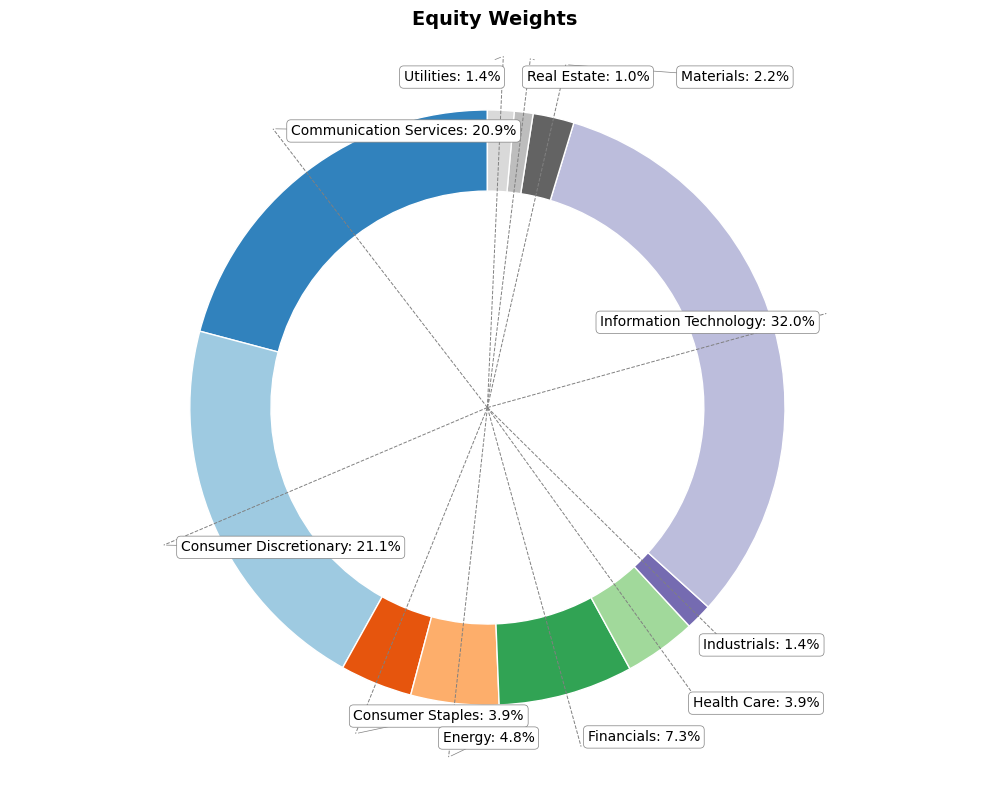



IR Returns columns:
['2Y_Treasury_ret', '5Y_Treasury_ret', '10Y_Treasury_ret', '30Y_Treasury_ret']

DV01-Balanced Interest Rate Portfolio (Calculated):
    Instrument  DV01_per_$1  Notional_$  DV01_$  DV01_Share
2Y          2Y      0.00018   587297.15  105.71        0.25
5Y          5Y      0.00047   224922.31  105.71        0.25
10Y        10Y      0.00080   132141.86  105.71        0.25
30Y        30Y      0.00190    55638.68  105.71        0.25

Combined Portfolio Returns (head):
              Equity  Interest Rate  Combined
2021-03-31  0.008561      -0.001860  0.003351
2021-04-01  0.015245       0.004515  0.009880
2021-04-05  0.021794      -0.000232  0.010781
2021-04-06 -0.000830       0.003850  0.001510
2021-04-07  0.011945      -0.001507  0.005219

Annualised Return and Volatility:
               Annualised Mean  Annualised Volatility
Equity                  0.1578                 0.2096
Interest Rate          -0.0529                 0.0791
Combined                0.0525       

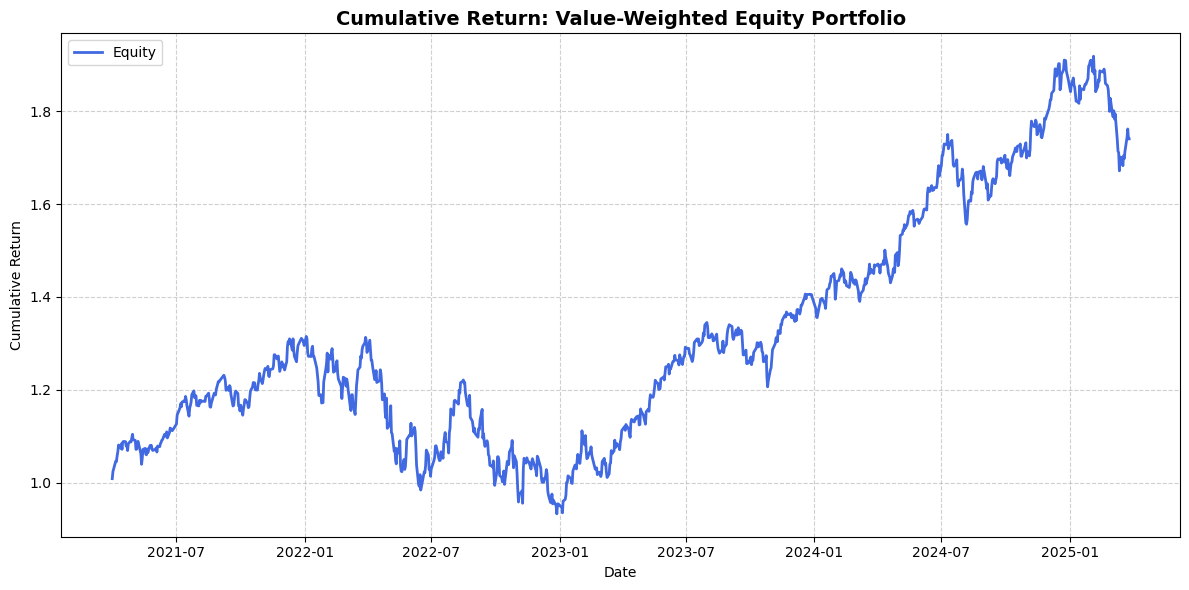

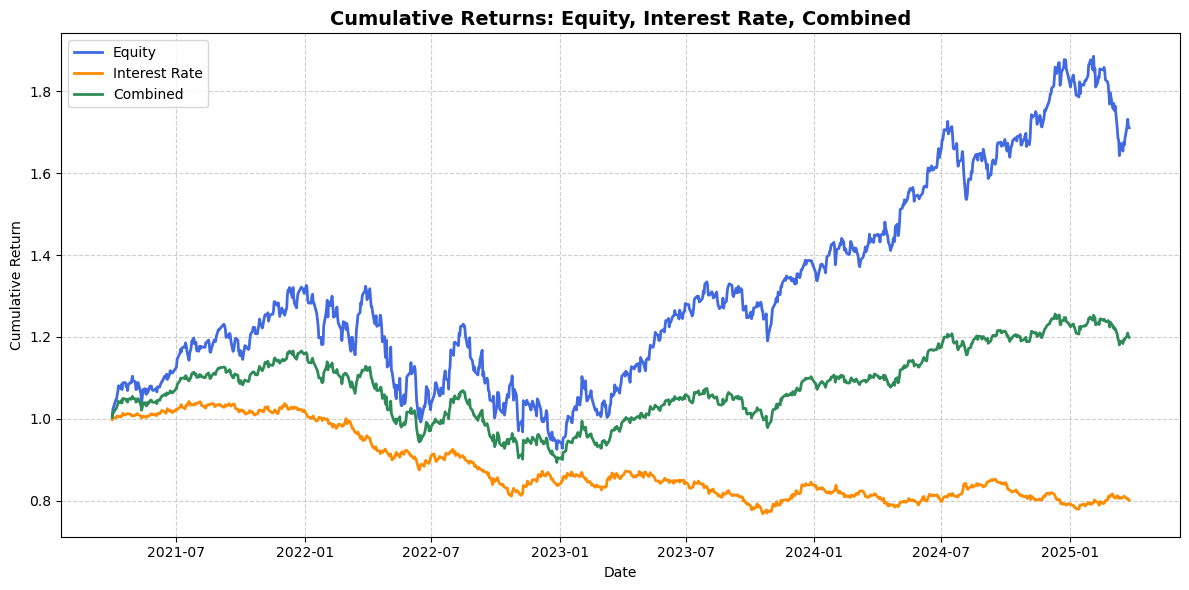


Saving results to: PORTFOLIO ASSIGNMENT 2\Phase1_Corrected_Portfolio.xlsx

Portfolio construction completed and saved successfully.


In [1]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from adjustText import adjust_text

# Step 1: Settings
start_date = "2021-03-30"
end_date = "2025-03-28"
output_folder = "PORTFOLIO ASSIGNMENT 2"
os.makedirs(output_folder, exist_ok=True)
output_file = os.path.join(output_folder, "Phase1_Corrected_Portfolio.xlsx")

# Step 2: Equity tickers by sector
sector_stocks = {
    'Communication Services': 'GOOGL',
    'Consumer Discretionary': 'AMZN',
    'Consumer Staples': 'PG',
    'Energy': 'XOM',
    'Financials': 'JPM',
    'Health Care': 'JNJ',
    'Industrials': 'HON',
    'Information Technology': 'AAPL',
    'Materials': 'LIN',
    'Real Estate': 'PLD',
    'Utilities': 'NEE'
}
sectors = list(sector_stocks.keys())
tickers = list(sector_stocks.values())

# Step 3: Download equity data
print("Downloading equity data...")
equity_data = yf.download(tickers, start=start_date, end=end_date)['Close'].dropna(how='all')
print("\nEquity Prices (head):")
print(equity_data.head())

# Step 4: Market cap weights
print("\nFetching market capitalizations...")
yf_data = yf.Tickers(" ".join(tickers))
market_caps = {ticker: yf_data.tickers[ticker].info.get("marketCap", 1e9) for ticker in tickers}
market_caps_series = pd.Series(market_caps)
weights_series = market_caps_series / market_caps_series.sum()
weights_df = pd.DataFrame({
    'Sector': sectors,
    'Ticker': tickers,
    'MarketCap ($B)': (market_caps_series / 1e9).round(2),
    'Weight': weights_series.round(4)
})
print("\nValue Weights Based on Market Cap:")
print(weights_df)

# Pie Chart for Weights
weights = weights_df['Weight']
labels = weights_df['Sector']
sizes = weights * 100
colors = plt.cm.tab20c(np.linspace(0, 1, len(weights)))

fig, ax = plt.subplots(figsize=(10, 8))
wedges, _ = ax.pie(
    sizes,
    colors=colors,
    startangle=90,
    radius=1.1,
    wedgeprops=dict(width=0.3, edgecolor='white')
)

texts = []
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2.
    x = np.cos(np.deg2rad(angle)) * 1.3
    y = np.sin(np.deg2rad(angle)) * 1.3
    ha = 'left' if x > 0 else 'right'
    label = f"{labels.iloc[i]}: {sizes.iloc[i]:.1f}%"
    text = ax.text(x, y, label, ha=ha, va='center', fontsize=10,
                   bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.5))
    ax.plot([0, x], [0, y], color='gray', linestyle='--', linewidth=0.7)
    texts.append(text)

adjust_text(texts, only_move={'points': 'y', 'texts': 'y'},
            arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

ax.set_title("Equity Weights", fontsize=14, fontweight='bold')
ax.axis('equal')
plt.tight_layout()
plt.show()

# Step 5: Equity simple returns
simple_returns = equity_data.pct_change().dropna()
value_weighted_returns = simple_returns.dot(weights_series)
value_weighted_returns.name = "Equity"

# Step 6: Interest Rate Data from FRED
print("\nDownloading FRED interest rate data...")
fred_symbols = {
    '2Y_Treasury': 'DGS2',
    '5Y_Treasury': 'DGS5',
    '10Y_Treasury': 'DGS10',
    '30Y_Treasury': 'DGS30'
}
fred_data = pdr.DataReader(list(fred_symbols.values()), 'fred', start=start_date, end=end_date)
fred_data.rename(columns={v: k for k, v in fred_symbols.items()}, inplace=True)
fred_data.dropna(inplace=True)

# Step 7: Duration & Convexity based IR returns
durations = {
    '2Y_Treasury': 1.8,
    '5Y_Treasury': 4.7,
    '10Y_Treasury': 8.0,
    '30Y_Treasury': 19.0
}
convexities = {
    '2Y_Treasury': 0.05,
    '5Y_Treasury': 0.25,
    '10Y_Treasury': 0.6,
    '30Y_Treasury': 1.5
}

delta_yields = fred_data.diff().dropna()
ir_returns = pd.DataFrame(index=delta_yields.index)

for col in durations:
    delta_y = delta_yields[col] / 100
    ir_returns[col + '_ret'] = -durations[col] * delta_y + 0.5 * convexities[col] * (delta_y ** 2)

print("\nIR Returns columns:")
print(ir_returns.columns.tolist())

# Step 8: Weighted IR Portfolio Return
ir_weights = {
    '2Y_Treasury_ret': 0.25,
    '5Y_Treasury_ret': 0.25,
    '10Y_Treasury_ret': 0.25,
    '30Y_Treasury_ret': 0.25
}
ir_portfolio_return = ir_returns[ir_weights.keys()].dot(pd.Series(ir_weights))
ir_portfolio_return.name = "Interest Rate"

# Step 8.1: Dynamically calculate DV01-balanced notional weights
# Approximate DV01 per $1 notional = Duration / 10,000
BOOK_VALUE = 1_000_000  # total IR portfolio notional

dv01_values = {k.replace('_Treasury', ''): round(d / 10000, 6) for k, d in durations.items()}
dv01_series = pd.Series(dv01_values)

# Inverse DV01 weighting
inv_dv01 = 1 / dv01_series.abs()
weights_dv01 = inv_dv01 / inv_dv01.sum()

# Calculate Notional, DV01$, and share
notionals = weights_dv01 * BOOK_VALUE
dv01_dollars = notionals * dv01_series
dv01_share = dv01_dollars / dv01_dollars.sum()

# Create a new DataFrame
dv01_data = pd.DataFrame({
    'Instrument': dv01_series.index,
    'DV01_per_$1': dv01_series.round(6),
    'Notional_$': notionals.round(2),
    'DV01_$': dv01_dollars.round(2),
    'DV01_Share': dv01_share.round(4)
})

print("\nDV01-Balanced Interest Rate Portfolio (Calculated):")
print(dv01_data)

# Step 9: Combined Portfolio
combined_index = value_weighted_returns.index.intersection(ir_portfolio_return.index)
combined_portfolio_return = 0.5 * value_weighted_returns[combined_index] + 0.5 * ir_portfolio_return[combined_index]
combined_portfolio_return.name = "Combined"

portfolio_returns = pd.concat([
    value_weighted_returns[combined_index],
    ir_portfolio_return[combined_index],
    combined_portfolio_return
], axis=1)

print("\nCombined Portfolio Returns (head):")
print(portfolio_returns.head())

# Step 10: Annualised Stats
print("\nAnnualised Return and Volatility:")
trading_days = 252
annual_stats = pd.DataFrame({
    "Annualised Mean": portfolio_returns.mean() * trading_days,
    "Annualised Volatility": portfolio_returns.std() * np.sqrt(trading_days)
})
print(annual_stats.round(4))

# Step 11: Plots
plt.style.use('default')

# Plot: Equity only
plt.figure(figsize=(12, 6))
cum_equity = (value_weighted_returns + 1).cumprod()
plt.plot(cum_equity, label="Equity", color='royalblue', linewidth=2)
plt.title("Cumulative Return: Value-Weighted Equity Portfolio", fontsize=14, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Plot: All portfolios
plt.figure(figsize=(12, 6))
cumulative_returns = (portfolio_returns + 1).cumprod()
colors = {'Equity': 'royalblue', 'Interest Rate': 'darkorange', 'Combined': 'seagreen'}
for col in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[col], label=col, color=colors[col], linewidth=2)
plt.title("Cumulative Returns: Equity, Interest Rate, Combined", fontsize=14, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Step 12: Save to Excel
print(f"\nSaving results to: {output_file}")
with pd.ExcelWriter(output_file) as writer:
    equity_data.to_excel(writer, sheet_name="Equity Prices")
    simple_returns.to_excel(writer, sheet_name="Equity Simple Returns")
    weights_df.to_excel(writer, sheet_name="Equity Weights", index=False)
    market_caps_series.rename("Market Cap").to_frame().to_excel(writer, sheet_name="Market Caps")
    value_weighted_returns.to_frame().to_excel(writer, sheet_name="Value Weighted Return")
    fred_data.to_excel(writer, sheet_name="FRED Data")
    delta_yields.to_excel(writer, sheet_name="Yield Changes")
    ir_returns.to_excel(writer, sheet_name="IR Returns")
    ir_portfolio_return.to_frame().to_excel(writer, sheet_name="IR Portfolio Return")
    portfolio_returns.to_excel(writer, sheet_name="Final Portfolio Returns")
    combined_portfolio_return.to_frame().to_excel(writer, sheet_name="Combined Portfolio Return")
    annual_stats.round(4).to_excel(writer, sheet_name="Annualised Stats")
    dv01_data.to_excel(writer, sheet_name="DV01 Balanced Weights", index=False)


print("\nPortfolio construction completed and saved successfully.")


In [3]:
print("\n=== SUMMARY: Portfolio Return Series Diagnostics ===")

# General Portfolio Return Sizes
print("\nNumber of Observations:")
print(f"{'Equity Portfolio:':<35} {value_weighted_returns.shape[0]} observations")
print(f"{'Interest Rate Portfolio:':<35} {ir_portfolio_return.shape[0]} observations")
print(f"{'Combined Portfolio:':<35} {portfolio_returns.shape[0]} observations")

# IR Instruments Breakdown
print("\nBreakdown of Individual Interest Rate Instrument Returns:")
for col in ir_returns.columns:
    print(f"{col:<35} {ir_returns[col].shape[0]} observations")

# Equity Return Matrix Info
print("\nEquity Simple Returns Shape (rows x columns):")
print(f"{simple_returns.shape[0]} rows (daily returns), {simple_returns.shape[1]} stocks")



=== SUMMARY: Portfolio Return Series Diagnostics ===

Number of Observations:
Equity Portfolio:                   1003 observations
Interest Rate Portfolio:            1000 observations
Combined Portfolio:                 996 observations

Breakdown of Individual Interest Rate Instrument Returns:
2Y_Treasury_ret                     1000 observations
5Y_Treasury_ret                     1000 observations
10Y_Treasury_ret                    1000 observations
30Y_Treasury_ret                    1000 observations

Equity Simple Returns Shape (rows x columns):
1003 rows (daily returns), 11 stocks


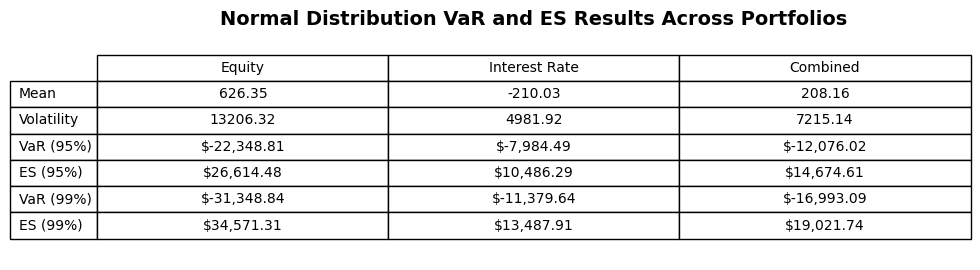


Table saved to: PORTFOLIO ASSIGNMENT 2/Normal_VaR_ES_Currency.xlsx


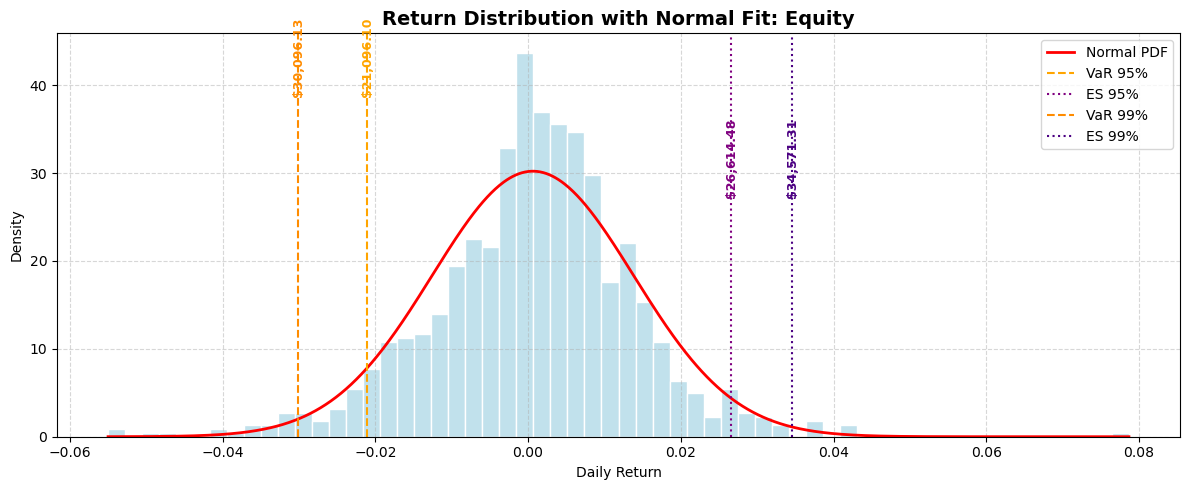

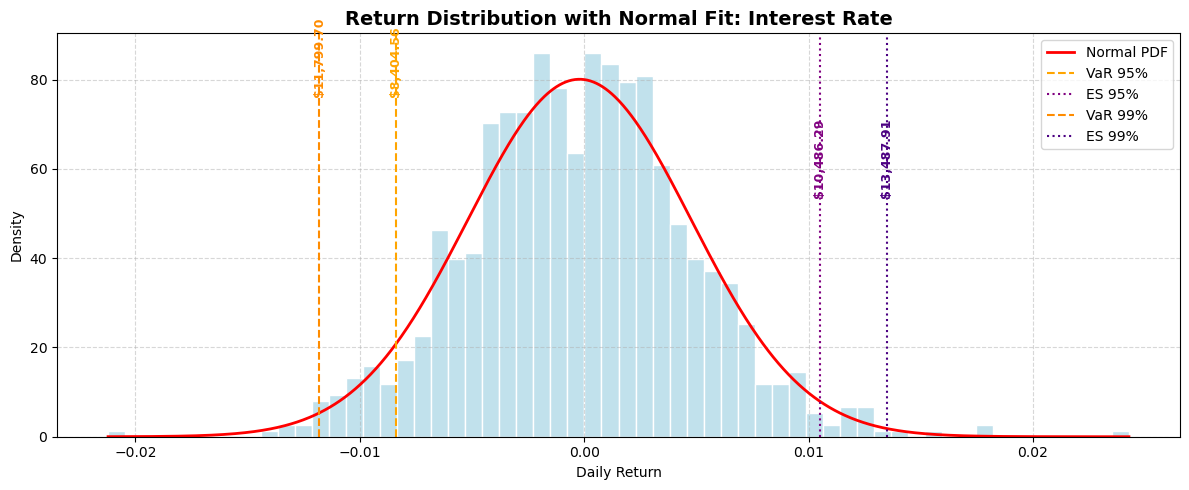

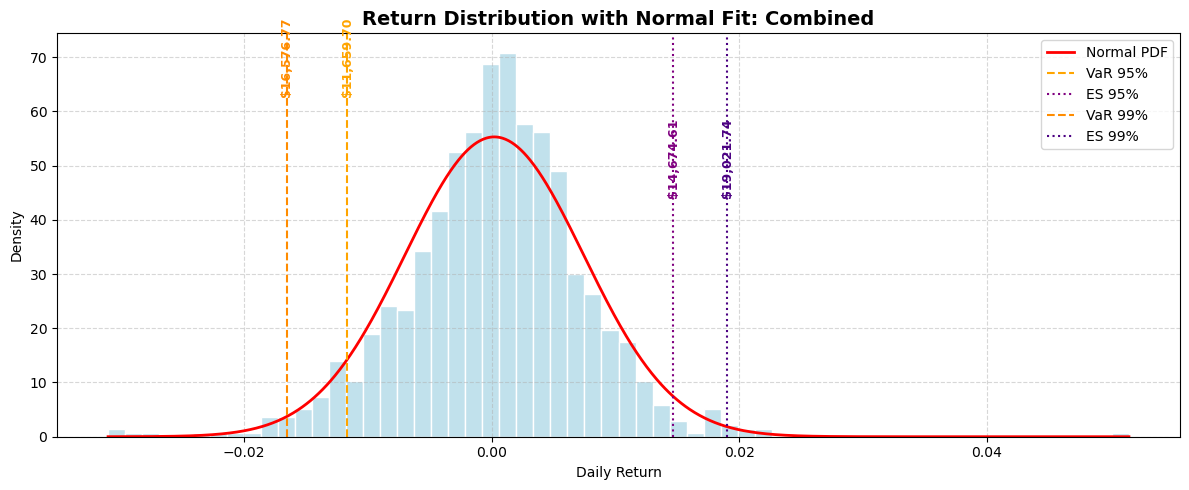

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# === PARAMETERS ===
cutoff_date = "2025-03-28"
confidence_levels = [0.95, 0.99]
portfolio_value = 1_000_000  # Assume $1,000,000 investment

# === Filter return data up to cutoff ===
returns_data = portfolio_returns.loc[:cutoff_date].dropna()

# === Currency formatting function ===
def currency(x):
    return f"${x:,.2f}"

# === Normal VaR & ES calculation ===
def normal_var_es(r, confidence_level):
    mu = r.mean()
    sigma = r.std()
    z = norm.ppf(confidence_level)
    var = -(mu + z * sigma) * portfolio_value
    es = -(mu - sigma * norm.pdf(z) / (1 - confidence_level)) * portfolio_value
    return var, es

# === Build summary metrics table ===
metrics = {
    "Model": ["Mean", "Volatility", "VaR (95%)", "ES (95%)", "VaR (99%)", "ES (99%)"]
}

for col in returns_data.columns:
    r = returns_data[col].dropna()
    mu = r.mean()
    sigma = r.std()
    var95, es95 = normal_var_es(r, 0.95)
    var99, es99 = normal_var_es(r, 0.99)

    metrics[col] = [
        round(mu * portfolio_value, 2),               # Mean in $
        round(sigma * portfolio_value, 2),            # Volatility in $
        currency(var95),
        currency(es95),
        currency(var99),
        currency(es99)
    ]

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics).set_index("Model")

# === Display Summary Table ===
plt.figure(figsize=(10, 2.8))
plt.axis("off")
plt.title("Normal Distribution VaR and ES Results Across Portfolios", fontsize=14, fontweight="bold")
table = plt.table(
    cellText=df_metrics.values,
    rowLabels=df_metrics.index,
    colLabels=df_metrics.columns,
    cellLoc='center',
    colLoc='center',
    loc='center'
)
table.scale(1.2, 1.5)
plt.tight_layout()
plt.show()

# === Save table to Excel ===
output_path = "PORTFOLIO ASSIGNMENT 2/Normal_VaR_ES_Currency.xlsx"
df_metrics.to_excel(output_path)
print(f"\nTable saved to: {output_path}")

# === Plot Return Distribution with VaR/ES overlay ===
def plot_return_distribution(portfolio):
    data = returns_data[portfolio].dropna()
    mu, sigma = data.mean(), data.std()

    plt.figure(figsize=(12, 5))
    sns.histplot(data, bins=60, kde=False, color='lightblue', stat='density', edgecolor='white')

    # Overlay normal PDF
    x = np.linspace(data.min(), data.max(), 1000)
    plt.plot(x, norm.pdf(x, mu, sigma), color='red', label="Normal PDF", linewidth=2)

    # Color map for annotations
    color_map = {
        "VaR 95%": "orange",
        "VaR 99%": "darkorange",
        "ES 95%": "purple",
        "ES 99%": "indigo"
    }

    # Add VaR and ES lines + annotations
    for cl in confidence_levels:
        alpha = 1 - cl
        z = norm.ppf(alpha)
        var = (mu + sigma * z) * portfolio_value
        es = (mu - sigma * norm.pdf(z) / alpha) * portfolio_value

        if cl == 0.95:
            var_color = color_map["VaR 95%"]
            es_color = color_map["ES 95%"]
        else:
            var_color = color_map["VaR 99%"]
            es_color = color_map["ES 99%"]

        # VaR line
        plt.axvline(var / portfolio_value, linestyle='--', color=var_color, label=f'VaR {int(cl*100)}%')
        # ES line
        plt.axvline(-es / portfolio_value, linestyle=':', color=es_color, label=f'ES {int(cl*100)}%')

        # Annotate values
        plt.text(var / portfolio_value, plt.ylim()[1]*0.85, f"${abs(var):,.2f}", 
                 color=var_color, fontsize=9, ha='center', rotation=90, fontweight='bold')
        plt.text(-es / portfolio_value, plt.ylim()[1]*0.6, f"${abs(es):,.2f}", 
                 color=es_color, fontsize=9, ha='center', rotation=90, fontweight='bold')

    plt.title(f"Return Distribution with Normal Fit: {portfolio}", fontsize=14, fontweight="bold")
    plt.xlabel("Daily Return")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# === Plot for each portfolio ===
for portfolio in returns_data.columns:
    plot_return_distribution(portfolio)


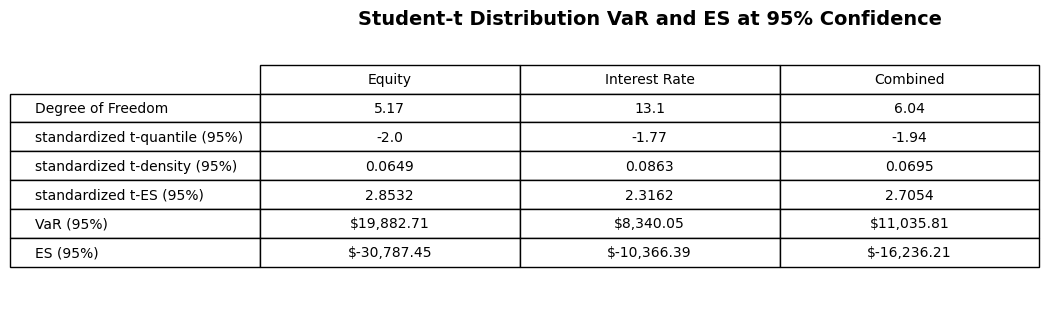

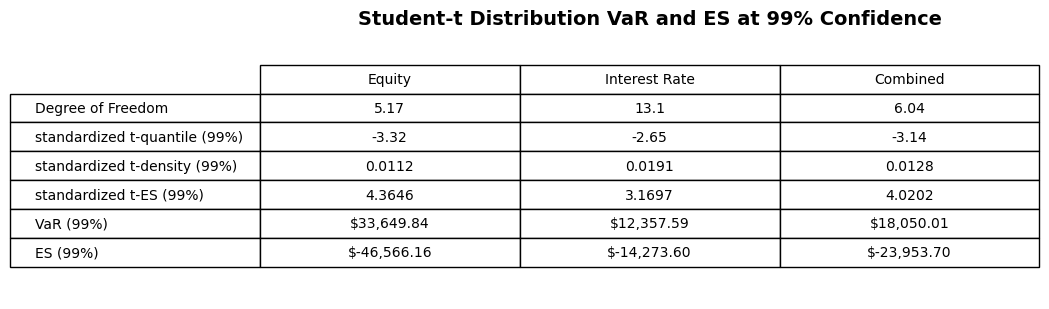


Student-t VaR & ES tables saved successfully to:
PORTFOLIO ASSIGNMENT 2/StudentT_VaR_ES_Both.xlsx


In [261]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# === PARAMETERS ===
cutoff_date = "2025-03-28"
portfolio_value = 1_000_000  # Assumed invested amount
confidence_levels = [0.95, 0.99]
returns_data = portfolio_returns.loc[:cutoff_date].dropna()

# === Helper: Format as currency ===
def currency(x):
    return f"${x:,.2f}"

# === Student-t VaR & ES Calculation ===
def student_t_stats(r, cl):
    df, loc, scale = t.fit(r)
    z = t.ppf(1 - cl, df)
    pdf = t.pdf(z, df)

    # Standardized Expected Shortfall
    std_es = ((df + z**2) / (df - 1)) * pdf / (1 - cl)

    # Convert to dollar VaR/ES
    var = -(loc + scale * z) * portfolio_value
    es = -(loc + scale * std_es) * portfolio_value

    return {
        "Degree of Freedom": round(df, 2),
        f"standardized t-quantile ({int(cl*100)}%)": round(z, 2),
        f"standardized t-density ({int(cl*100)}%)": round(pdf, 4),
        f"standardized t-ES ({int(cl*100)}%)": round(std_es, 4),
        f"VaR ({int(cl*100)}%)": currency(var),
        f"ES ({int(cl*100)}%)": currency(es)
    }

# === Compute for all portfolios ===
records_95 = []
records_99 = []

for col in returns_data.columns:
    r = returns_data[col].dropna()
    stats_95 = student_t_stats(r, 0.95)
    stats_99 = student_t_stats(r, 0.99)
    records_95.append(stats_95)
    records_99.append(stats_99)

# Convert to DataFrames
df_95 = pd.DataFrame(records_95, index=returns_data.columns).T
df_99 = pd.DataFrame(records_99, index=returns_data.columns).T

# === Plot as Table Function ===
def show_table(df, title):
    plt.figure(figsize=(11, 3.2))
    plt.axis("off")
    plt.title(title, fontsize=14, fontweight="bold")
    table = plt.table(
        cellText=df.values,
        rowLabels=df.index,
        colLabels=df.columns,
        cellLoc='center',
        colLoc='center',
        loc='center'
    )
    table.scale(1.2, 1.6)
    plt.tight_layout()
    plt.show()

# === Display Tables ===
show_table(df_95, "Student-t Distribution VaR and ES at 95% Confidence")
show_table(df_99, "Student-t Distribution VaR and ES at 99% Confidence")

# === Save to Excel ===
excel_path = "PORTFOLIO ASSIGNMENT 2/StudentT_VaR_ES_Both.xlsx"
with pd.ExcelWriter(excel_path) as writer:
    df_95.to_excel(writer, sheet_name="StudentT_95")
    df_99.to_excel(writer, sheet_name="StudentT_99")

print(f"\nStudent-t VaR & ES tables saved successfully to:\n{excel_path}")


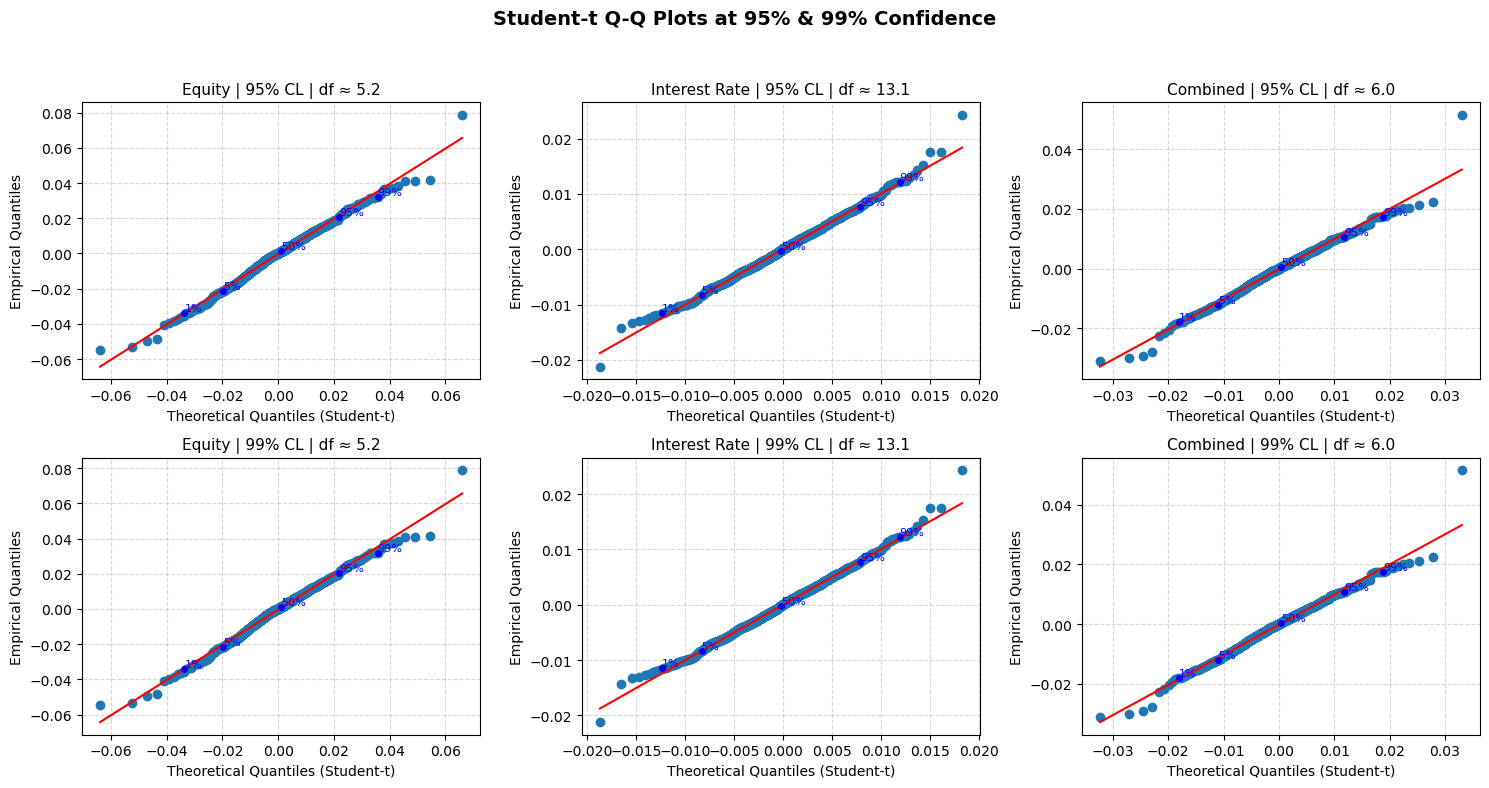

In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, probplot

# === Prepare ===
returns_data = portfolio_returns.loc[:'2025-03-28'].dropna()
confidence_levels = [0.95, 0.99]

# === Improved Q-Q Plot Function ===
def qq_plot_student_t_clean(data, conf_levels=[0.95, 0.99]):
    portfolios = data.columns
    fig, axs = plt.subplots(len(conf_levels), len(portfolios), figsize=(5 * len(portfolios), 4 * len(conf_levels)), squeeze=False)

    for i, cl in enumerate(conf_levels):
        for j, port in enumerate(portfolios):
            r = data[port].dropna()
            df, loc, scale = t.fit(r)
            ax = axs[i, j]

            # Q-Q plot
            (osm, osr), (slope, intercept, _) = probplot(r, dist=t, sparams=(df, loc, scale))
            ax.plot(osm, osr, 'o', label='Empirical')
            ax.plot(osm, slope * osm + intercept, 'r-', label='Theoretical')

            # Mark critical quantiles with short ticks only
            for q in [0.01, 0.05, 0.5, 0.95, 0.99]:
                theo_q = t.ppf(q, df, loc=loc, scale=scale)
                emp_q = np.quantile(r, q)
                ax.plot(theo_q, emp_q, marker='o', markersize=4, label=None, color='blue')
                ax.text(theo_q, emp_q, f'{int(q*100)}%', fontsize=8, ha='left', va='bottom', color='blue')

            # Titles and axis
            ax.set_title(f"{port} | {int(cl*100)}% CL | df ≈ {df:.1f}", fontsize=11)
            ax.set_xlabel("Theoretical Quantiles (Student-t)", fontsize=10)
            ax.set_ylabel("Empirical Quantiles", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.5)

    plt.suptitle("Student-t Q-Q Plots at 95% & 99% Confidence", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# === Run it ===
qq_plot_student_t_clean(returns_data)

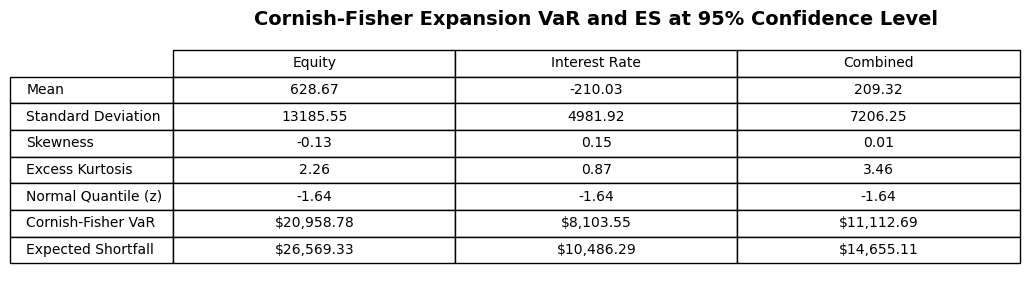

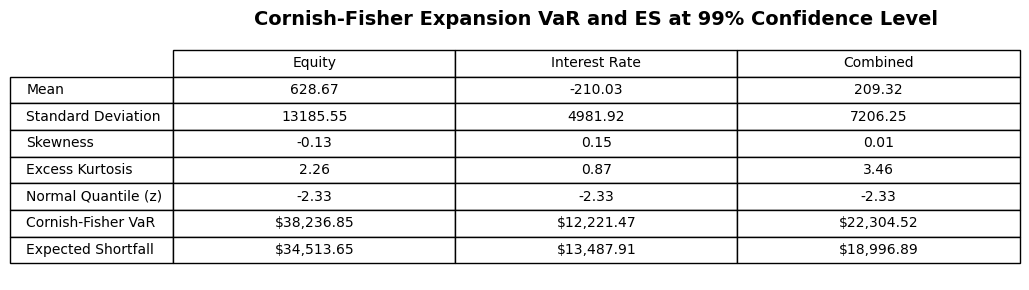

Cornish-Fisher results saved to Excel.


In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# === PARAMETERS ===
cutoff_date = "2025-03-28"
confidence_levels = [0.95, 0.99]
portfolio_value = 1_000_000

# === DATA PREPARATION ===
returns_data = portfolio_returns.loc[:cutoff_date].dropna()

# === CORNISH-FISHER FUNCTION ===
def cornish_fisher_metrics(x, cl):
    alpha = 1 - cl
    mu = x.mean()
    sigma = x.std()
    skew = x.skew()
    kurt = x.kurtosis()
    
    z = norm.ppf(alpha)
    
    # Cornish-Fisher adjusted quantile
    z_cf = z + (1/6)*(z**2 - 1)*skew + (1/24)*(z**3 - 3*z)*kurt - (1/36)*(2*z**3 - 5*z)*skew**2
    
    var_cf = -(mu + z_cf * sigma) * portfolio_value
    
    # ES approximation using standard Normal method
    es_norm = -(mu - sigma * norm.pdf(z) / alpha) * portfolio_value
    
    return {
        "Mean": round(mu * portfolio_value, 2),
        "Standard Deviation": round(sigma * portfolio_value, 2),
        "Skewness": round(skew, 2),
        "Excess Kurtosis": round(kurt, 2),
        "Normal Quantile (z)": round(z, 2),
        "Cornish-Fisher VaR": f"${var_cf:,.2f}",
        "Expected Shortfall": f"${es_norm:,.2f}"
    }

# === TABLE BUILDER ===
def build_table_for_cl(cl):
    table = {
        "Metric": ["Mean", "Standard Deviation", "Skewness", "Excess Kurtosis", 
                   "Normal Quantile (z)", "Cornish-Fisher VaR", "Expected Shortfall"]
    }
    for col in returns_data.columns:
        values = cornish_fisher_metrics(returns_data[col].dropna(), cl)
        table[col] = [values[k] for k in table["Metric"]]
    
    return pd.DataFrame(table).set_index("Metric")

# === PLOTTING TABLE ===
def plot_table(df, title):
    plt.figure(figsize=(11, 3))
    plt.axis('off')
    plt.title(title, fontsize=14, fontweight="bold")
    
    table = plt.table(
        cellText=df.values,
        rowLabels=df.index,
        colLabels=df.columns,
        cellLoc='center',
        colLoc='center',
        loc='center'
    )
    table.scale(1.3, 1.5)
    plt.tight_layout()
    plt.show()

# === RUN FOR BOTH CONFIDENCE LEVELS ===
df_95 = build_table_for_cl(0.95)
df_99 = build_table_for_cl(0.99)

plot_table(df_95, "Cornish-Fisher Expansion VaR and ES at 95% Confidence Level")
plot_table(df_99, "Cornish-Fisher Expansion VaR and ES at 99% Confidence Level")

# === EXPORT ===
with pd.ExcelWriter("PORTFOLIO ASSIGNMENT 2/CornishFisher_VaR_ES_Tables.xlsx") as writer:
    df_95.to_excel(writer, sheet_name="Cornish-Fisher 95")  
    df_99.to_excel(writer, sheet_name="Cornish-Fisher 99") 

print("Cornish-Fisher results saved to Excel.")


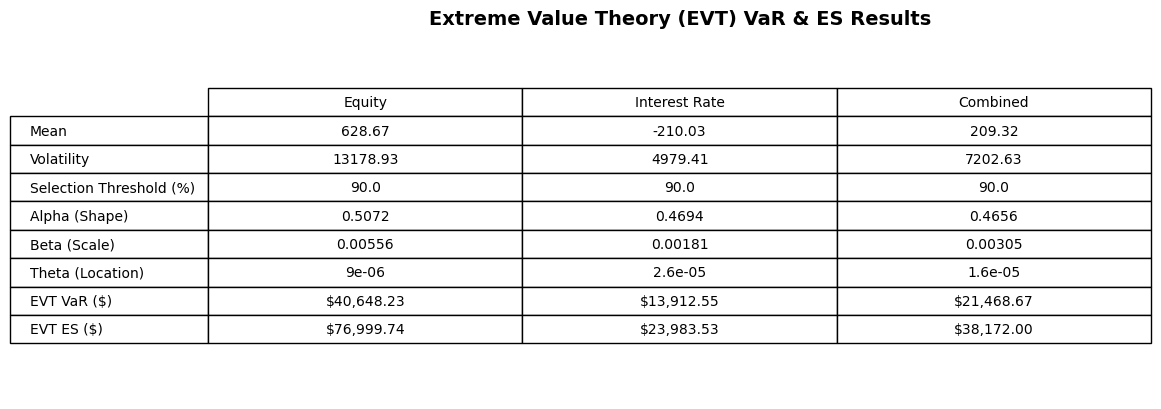


EVT VaR & ES results saved successfully to:
PORTFOLIO ASSIGNMENT 2/Phase2_EVT_VaR_ES.xlsx


In [273]:
import numpy as np
import pandas as pd
from scipy.stats import genpareto
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# === PARAMETERS ===
cutoff_date = "2025-03-28"
threshold_quantile = 0.90   # 90th percentile threshold
confidence_level = 0.99     # 99% VaR
portfolio_value = 1_000_000 # $1M investment

# === DATA FILTERING ===
returns_data = portfolio_returns.loc[:cutoff_date].dropna()

# === Helper: currency formatting ===
def currency(x):
    return f"${x:,.2f}"

# === EVT VaR and ES Calculation Function ===
def evt_var_es(x, alpha=0.99, threshold_q=0.90, value=1_000_000):
    x = np.array(x.dropna())
    mu, sigma = x.mean(), x.std()

    # Define threshold
    threshold = np.quantile(x, 1 - threshold_q)

    # Excesses below threshold (tail losses)
    excesses = -x[x < threshold] - abs(threshold)

    if len(excesses) < 10:
        return mu * value, sigma * value, np.nan, np.nan, np.nan, np.nan, np.nan

    # Fit GPD to excesses
    shape, loc, scale = genpareto.fit(excesses)

    # Parameters for VaR/ES
    n = len(x)
    n_exc = len(excesses)
    quantile_prob = (1 - alpha) * n / n_exc

    # EVT VaR (return-space)
    var_ret = abs(threshold) + scale / shape * (quantile_prob ** -shape - 1)

    # EVT ES
    if shape < 1:
        es = (var_ret + scale - shape * abs(threshold)) / (1 - shape)
    else:
        es = np.nan  # ES is infinite when shape ≥ 1

    return mu * value, sigma * value, shape, scale, loc, var_ret * value, es * value

# === Run EVT for each portfolio ===
rows = []
for col in returns_data.columns:
    mu, vol, alpha_hat, beta_hat, theta_hat, var_dollar, es_dollar = evt_var_es(
        returns_data[col], confidence_level, threshold_quantile, portfolio_value
    )

    rows.append({
        "Portfolio": col,
        "Mean": round(mu, 2),
        "Volatility": round(vol, 2),
        "Selection Threshold (%)": round(threshold_quantile * 100, 2),
        "Alpha (Shape)": round(alpha_hat, 4) if not np.isnan(alpha_hat) else "N/A",
        "Beta (Scale)": round(beta_hat, 6) if not np.isnan(beta_hat) else "N/A",
        "Theta (Location)": round(theta_hat, 6) if not np.isnan(theta_hat) else "N/A",
        "EVT VaR ($)": currency(var_dollar) if not np.isnan(var_dollar) else "N/A",
        "EVT ES ($)": currency(es_dollar) if not np.isnan(es_dollar) else "N/A"
    })

# === Convert to DataFrame ===
df_evt = pd.DataFrame(rows).set_index("Portfolio").T

# === Display Table ===
plt.figure(figsize=(12, 4.2))
plt.axis("off")
plt.title("Extreme Value Theory (EVT) VaR & ES Results", fontsize=14, fontweight="bold")
table = plt.table(
    cellText=df_evt.values,
    rowLabels=df_evt.index,
    colLabels=df_evt.columns,
    cellLoc="center",
    colLoc="center",
    loc="center"
)
table.scale(1.2, 1.5)
plt.tight_layout()
plt.show()

# === Save to Excel ===
output_path = "PORTFOLIO ASSIGNMENT 2/Phase2_EVT_VaR_ES.xlsx"
df_evt.to_excel(output_path)
print(f"\nEVT VaR & ES results saved successfully to:\n{output_path}")


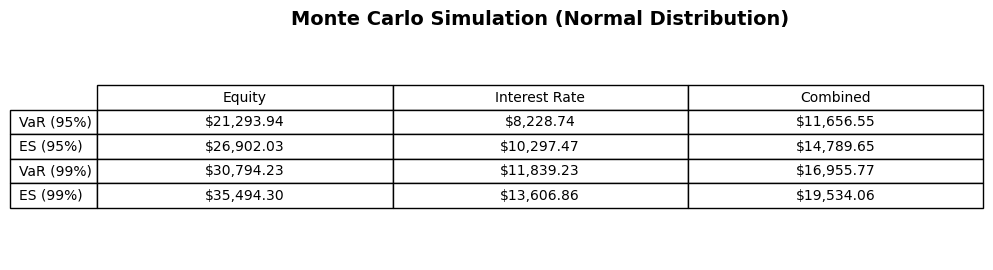

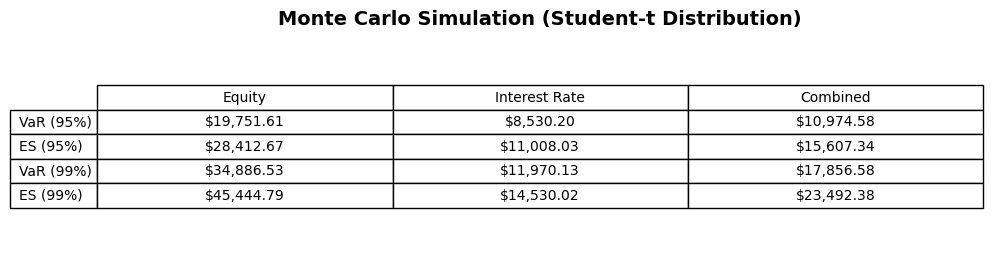

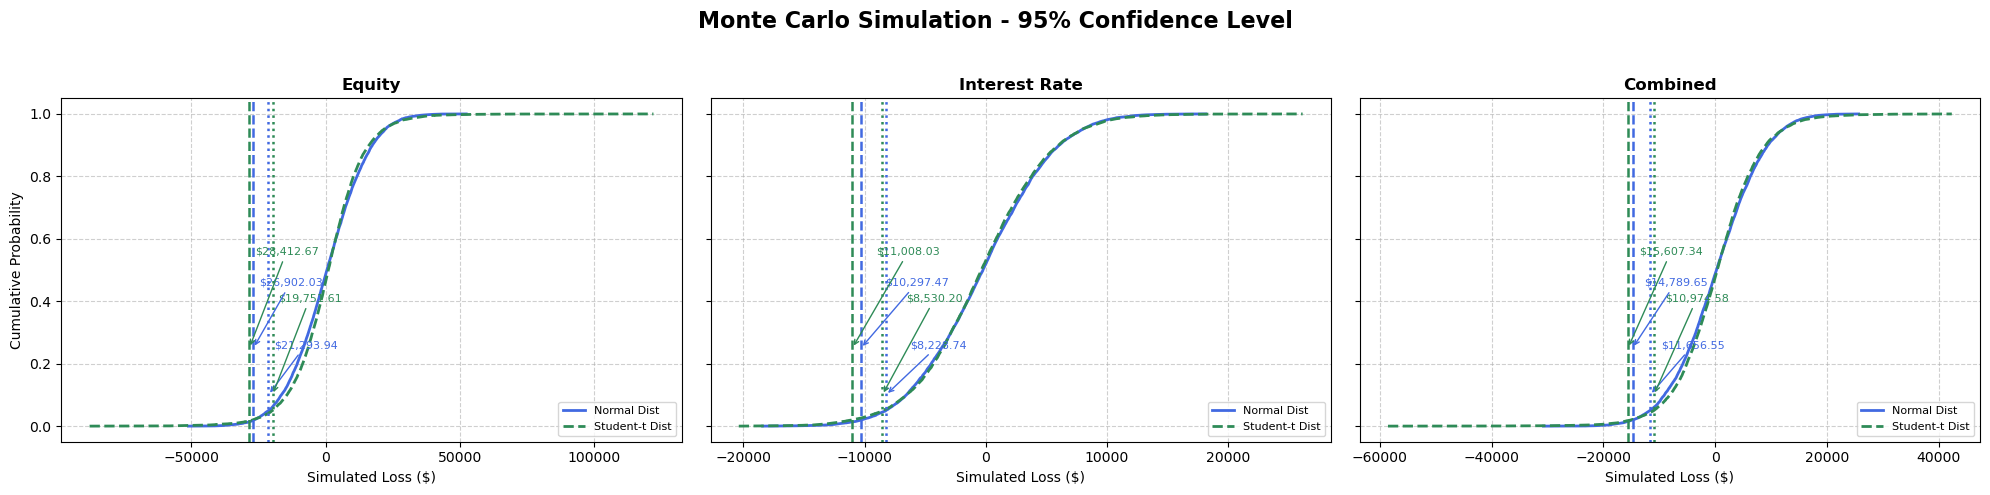

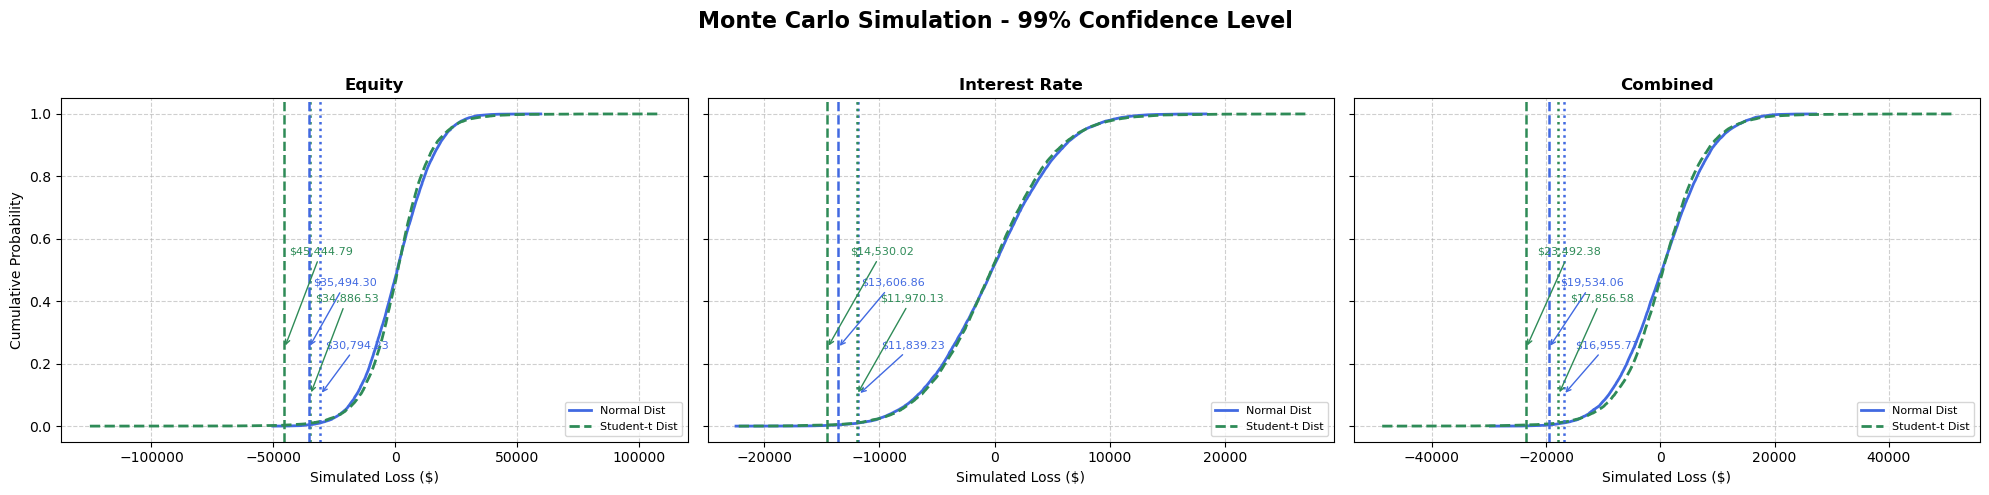

Monte Carlo simulation tables and CDF separate plots saved successfully.


In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t

# === PARAMETERS ===
cutoff_date = "2025-03-28"
confidence_levels = [0.95, 0.99]
portfolio_value = 1_000_000
n_simulations = 10000

# === Prepare Data ===
returns_data = portfolio_returns.loc[:cutoff_date].dropna()
portfolios = returns_data.columns.tolist()

# === Formatting Function ===
def currency(x): 
    return f"${abs(x):,.2f}"

# === Monte Carlo (Normal) ===
def mcs_normal(r, cl):
    mu, sigma = r.mean(), r.std()
    sims = np.random.normal(mu, sigma, n_simulations)
    var = np.percentile(sims, (1 - cl) * 100)  # already negative
    es = sims[sims <= var].mean()
    return var * portfolio_value, es * portfolio_value, sims * portfolio_value

# === Monte Carlo (Student-t) ===
def mcs_student_t(r, cl):
    df, loc, scale = t.fit(r)
    sims = t.rvs(df, loc=loc, scale=scale, size=n_simulations)
    var = np.percentile(sims, (1 - cl) * 100)  # already negative
    es = sims[sims <= var].mean()
    return var * portfolio_value, es * portfolio_value, sims * portfolio_value

# === Build Tables and Simulated Data ===
def build_mcs_table_and_sims(mcs_func):
    table_data = []
    sim_dict = {95: {}, 99: {}}

    for col in returns_data.columns:
        r = returns_data[col].dropna()
        row = []
        for cl in confidence_levels:
            var, es, sims = mcs_func(r, cl)
            row += [currency(var), currency(es)]
            sim_dict[int(cl*100)][col] = (sims, var)
        table_data.append(row)

    df = pd.DataFrame(
        table_data,
        columns=["VaR (95%)", "ES (95%)", "VaR (99%)", "ES (99%)"],
        index=returns_data.columns
    ).T

    return df, sim_dict

# === Display Table Function ===
def display_table(df, title, figsize=(10, 2.8), scale=(1.1, 1.4)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.title(title, fontsize=14, fontweight="bold")
    tbl = plt.table(
        cellText=df.values,
        rowLabels=df.index,
        colLabels=df.columns,
        cellLoc="center",
        colLoc="center",
        loc="center"
    )
    tbl.scale(*scale)
    plt.tight_layout()
    plt.show()

# === Updated Plotting Function (Standard Left-Tail Style) ===
def plot_cdf_separate(sims_norm, sims_t, title_prefix):
    for cl in [95, 99]:
        fig, axes = plt.subplots(1, len(portfolios), figsize=(20, 5), sharey=True)

        for i, col in enumerate(portfolios):
            norm_sims, var_norm = sims_norm[cl][col]
            t_sims, var_t = sims_t[cl][col]

            es_norm = norm_sims[norm_sims <= var_norm].mean()
            es_t = t_sims[t_sims <= var_t].mean()

            sorted_norm = np.sort(norm_sims)
            sorted_t = np.sort(t_sims)
            cum_probs = np.linspace(0, 1, len(sorted_norm))

            ax = axes[i]
            ax.plot(sorted_norm, cum_probs, label="Normal Dist", color="royalblue", linewidth=2)
            ax.plot(sorted_t, cum_probs, label="Student-t Dist", color="seagreen", linestyle="--", linewidth=2)

            # VaR Lines
            ax.axvline(x=var_norm, color="royalblue", linestyle=":", linewidth=1.8)
            ax.axvline(x=var_t, color="seagreen", linestyle=":", linewidth=1.8)

            # ES Lines
            ax.axvline(x=es_norm, color="royalblue", linestyle="--", linewidth=1.8)
            ax.axvline(x=es_t, color="seagreen", linestyle="--", linewidth=1.8)

            # Annotations (adjusted positions)
            ax.annotate(f"{currency(var_norm)}", xy=(var_norm, 0.1), xytext=(var_norm + 2000, 0.25),
                        arrowprops=dict(arrowstyle="->", color="royalblue"), fontsize=8, color="royalblue")
            ax.annotate(f"{currency(var_t)}", xy=(var_t, 0.1), xytext=(var_t + 2000, 0.4),
                        arrowprops=dict(arrowstyle="->", color="seagreen"), fontsize=8, color="seagreen")
            ax.annotate(f"{currency(es_norm)}", xy=(es_norm, 0.25), xytext=(es_norm + 2000, 0.45),
                        arrowprops=dict(arrowstyle="->", color="royalblue"), fontsize=8, color="royalblue")
            ax.annotate(f"{currency(es_t)}", xy=(es_t, 0.25), xytext=(es_t + 2000, 0.55),
                        arrowprops=dict(arrowstyle="->", color="seagreen"), fontsize=8, color="seagreen")

            # Plot labels
            ax.set_title(f"{col}", fontsize=12, fontweight="bold")
            ax.set_xlabel("Simulated Loss ($)")
            if i == 0:
                ax.set_ylabel("Cumulative Probability")
            ax.grid(True, linestyle="--", alpha=0.6)
            ax.legend(fontsize=8, loc="lower right")

        plt.suptitle(f"{title_prefix} - {cl}% Confidence Level", fontsize=16, fontweight="bold")
        plt.subplots_adjust(wspace=0.3, hspace=0.3)  # <-- spacing fix
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


# === Run All ===
df_norm, sims_norm = build_mcs_table_and_sims(mcs_normal)
df_t, sims_t = build_mcs_table_and_sims(mcs_student_t)

# === Display Tables ===
display_table(df_norm, "Monte Carlo Simulation (Normal Distribution)")
display_table(df_t, "Monte Carlo Simulation (Student-t Distribution)")

# === Display CDFs ===
plot_cdf_separate(sims_norm, sims_t, "Monte Carlo Simulation")

# === Save to Excel ===
with pd.ExcelWriter("PORTFOLIO ASSIGNMENT 2/MCS_Tables_Cleaned.xlsx") as writer:
    df_norm.to_excel(writer, sheet_name="Normal MCS")
    df_t.to_excel(writer, sheet_name="Student-t MCS")

print("Monte Carlo simulation tables and CDF separate plots saved successfully.")


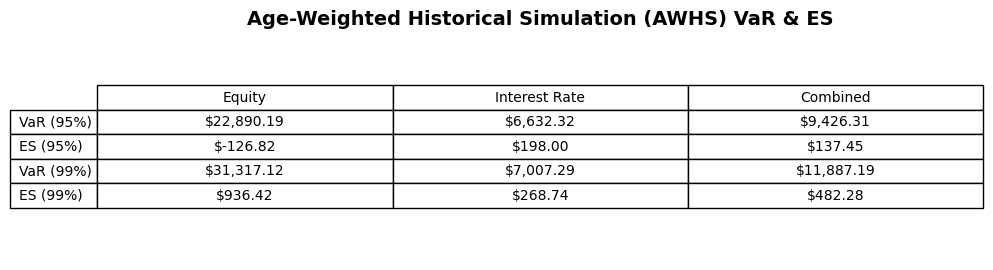


AWHS VaR & ES results saved to:
PORTFOLIO ASSIGNMENT 2/AWHS_VaR_ES.xlsx


In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === PARAMETERS ===
cutoff_date = "2025-03-28"
portfolio_value = 1_000_000           # $1M investment
lambda_decay = 0.94                   # Decay factor (more weight to recent data)
confidence_levels = [0.95, 0.99]

# === LOAD & PREPARE DATA ===
returns_data = portfolio_returns.loc[:cutoff_date].dropna()
portfolios = returns_data.columns.tolist()

# === Helper: Format as Currency ===
def currency(x):
    return f"${x:,.2f}"

# === Age-Weighted Historical Simulation VaR & ES ===
def awhs_var_es(returns, cl, lam):
    n = len(returns)
    sorted_returns = np.sort(returns)

    # Exponential decay weights (latest has highest weight)
    weights = np.array([(1 - lam) * lam**(n - i - 1) for i in range(n)])
    weights /= weights.sum()  # Normalize to sum = 1

    # Cumulative weights after sorting returns
    sorted_indices = np.argsort(returns)
    sorted_weights = weights[sorted_indices]
    cum_weights = np.cumsum(sorted_weights)

    # Find VaR level
    var_index = np.searchsorted(cum_weights, 1 - cl)
    var = -sorted_returns[var_index]

    # Expected Shortfall (ES): weighted average of returns worse than VaR
    es_mask = cum_weights >= 1 - cl
    es_weights = sorted_weights[es_mask]
    es_losses = sorted_returns[es_mask]
    es = -np.sum(es_losses * es_weights) / es_weights.sum()

    return var * portfolio_value, es * portfolio_value

# === Build AWHS VaR & ES Table ===
results = []
for col in portfolios:
    r = returns_data[col].dropna()
    row = []
    for cl in confidence_levels:
        var, es = awhs_var_es(r, cl, lambda_decay)
        row += [currency(var), currency(es)]
    results.append(row)

# === Create DataFrame ===
df_awhs = pd.DataFrame(
    results,
    index=portfolios,
    columns=["VaR (95%)", "ES (95%)", "VaR (99%)", "ES (99%)"]
).T

# === Display Table Function ===
def display_table(df, title, figsize=(10, 2.8), scale=(1.1, 1.4)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.title(title, fontsize=14, fontweight="bold")
    table = plt.table(
        cellText=df.values,
        rowLabels=df.index,
        colLabels=df.columns,
        cellLoc='center',
        colLoc='center',
        loc='center'
    )
    table.scale(*scale)
    plt.tight_layout()
    plt.show()

# === Display AWHS Table ===
display_table(df_awhs, "Age-Weighted Historical Simulation (AWHS) VaR & ES")

# === Save to Excel ===
output_path = "PORTFOLIO ASSIGNMENT 2/AWHS_VaR_ES.xlsx"
df_awhs.to_excel(output_path, sheet_name="AWHS VaR ES")
print(f"\nAWHS VaR & ES results saved to:\n{output_path}")


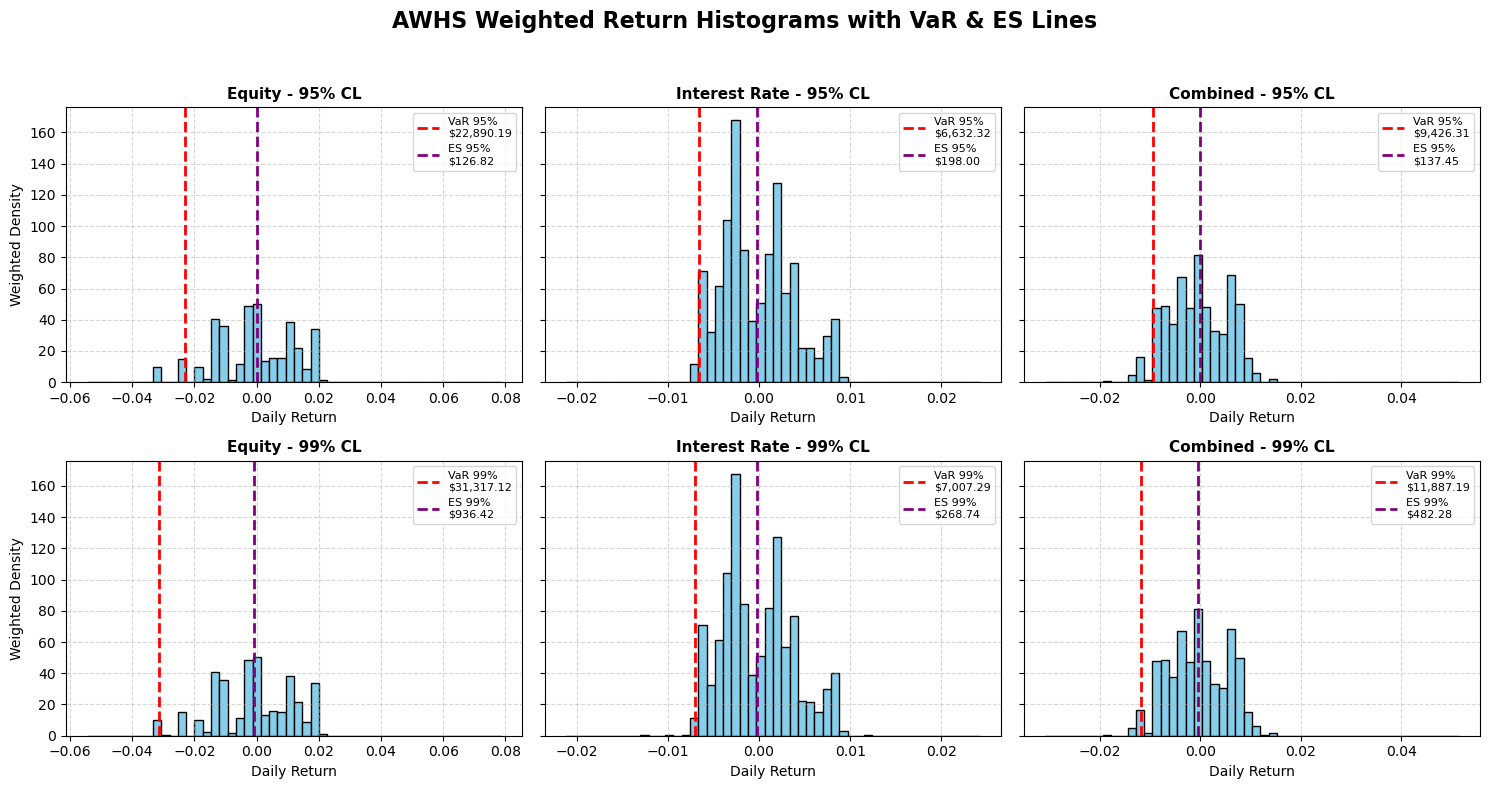

In [281]:
def plot_awhs_histogram_subplots(returns_data, cl_list, lambda_decay, portfolio_value):
    n_cols = len(returns_data.columns)
    n_rows = len(cl_list)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharey='row')

    if n_rows == 1:
        axes = np.array([axes])  # Ensure axes is 2D for consistent indexing

    for i, cl in enumerate(cl_list):
        for j, col in enumerate(returns_data.columns):
            r = returns_data[col].dropna()
            n = len(r)

            # Sort and weight returns
            sorted_indices = np.argsort(r)
            sorted_returns = r.iloc[sorted_indices].values
            weights = np.array([(1 - lambda_decay) * lambda_decay**(n - k - 1) for k in range(n)])
            weights /= weights.sum()
            weights_sorted = weights[sorted_indices]

            # Cumulative weights
            cum_weights = np.cumsum(weights_sorted)
            var_index = np.searchsorted(cum_weights, 1 - cl)
            var = -sorted_returns[var_index] * portfolio_value

            # ES: weighted average of losses worse than VaR
            es_mask = cum_weights >= 1 - cl
            es = -np.sum(sorted_returns[es_mask] * weights_sorted[es_mask]) / weights_sorted[es_mask].sum()
            es *= portfolio_value

            # Plotting
            ax = axes[i, j]
            ax.hist(r, bins=50, weights=weights, color='skyblue', edgecolor='black', density=True)
            ax.axvline(-var / portfolio_value, color='red', linestyle='--', linewidth=2, label=f"VaR {int(cl*100)}%\n{currency(var)}")
            ax.axvline(-es / portfolio_value, color='purple', linestyle='--', linewidth=2, label=f"ES {int(cl*100)}%\n{currency(es)}")

            # Titles and Labels
            ax.set_title(f"{col} - {int(cl*100)}% CL", fontsize=11, fontweight='bold')
            ax.set_xlabel("Daily Return")
            if j == 0:
                ax.set_ylabel("Weighted Density")
            ax.legend(fontsize=8, loc="upper right")
            ax.grid(True, linestyle="--", alpha=0.5)

    plt.suptitle("AWHS Weighted Return Histograms with VaR & ES Lines", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
plot_awhs_histogram_subplots(returns_data, confidence_levels, lambda_decay, portfolio_value)


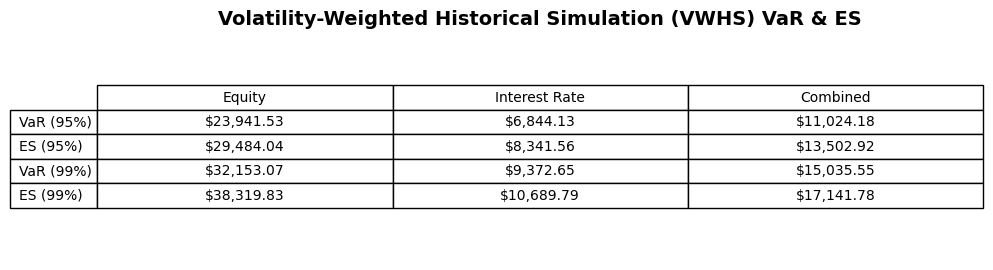


VWHS VaR & ES results saved to:
PORTFOLIO ASSIGNMENT 2/VWHS_VaR_ES.xlsx


In [283]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === PARAMETERS ===
cutoff_date = "2025-03-28"
portfolio_value = 1_000_000           # Assume $1M investment
confidence_levels = [0.95, 0.99]
window = 20                           # Rolling window for volatility

# === Load Data ===
returns_data = portfolio_returns.loc[:cutoff_date].dropna()
portfolios = returns_data.columns.tolist()

# === Currency Formatting ===
def currency(x):
    return f"${abs(x):,.2f}"

# === VWHS VaR & ES Function ===
def vwhs_var_es(returns, cl, window):
    # Rolling volatility
    rolling_vol = returns.rolling(window=window).std()
    current_vol = rolling_vol.iloc[-1]

    # Drop initial NaNs and align dates
    valid_dates = rolling_vol.dropna().index
    scaled_returns = returns.loc[valid_dates] * (current_vol / rolling_vol.loc[valid_dates])

    # Sort scaled returns for VaR/ES
    sorted_returns = np.sort(scaled_returns.dropna())
    var_index = int((1 - cl) * len(sorted_returns))
    var = -sorted_returns[var_index]
    es = -sorted_returns[:var_index].mean()

    return var * portfolio_value, es * portfolio_value

# === Build Table ===
results = []
for col in portfolios:
    r = returns_data[col].dropna()
    row = []
    for cl in confidence_levels:
        var, es = vwhs_var_es(r, cl, window)
        row += [currency(var), currency(es)]
    results.append(row)

# === Create DataFrame ===
df_vwhs = pd.DataFrame(
    results,
    index=portfolios,
    columns=["VaR (95%)", "ES (95%)", "VaR (99%)", "ES (99%)"]
).T

# === Display Table ===
def display_table(df, title, figsize=(10, 2.8), scale=(1.1, 1.4)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.title(title, fontsize=14, fontweight="bold")
    table = plt.table(
        cellText=df.values,
        rowLabels=df.index,
        colLabels=df.columns,
        cellLoc='center',
        colLoc='center',
        loc='center'
    )
    table.scale(*scale)
    plt.tight_layout()
    plt.show()

# === Show VWHS Table ===
display_table(df_vwhs, "Volatility-Weighted Historical Simulation (VWHS) VaR & ES")

# === Save to Excel ===
output_path = "PORTFOLIO ASSIGNMENT 2/VWHS_VaR_ES.xlsx"
df_vwhs.to_excel(output_path, sheet_name="VWHS")
print(f"\nVWHS VaR & ES results saved to:\n{output_path}")


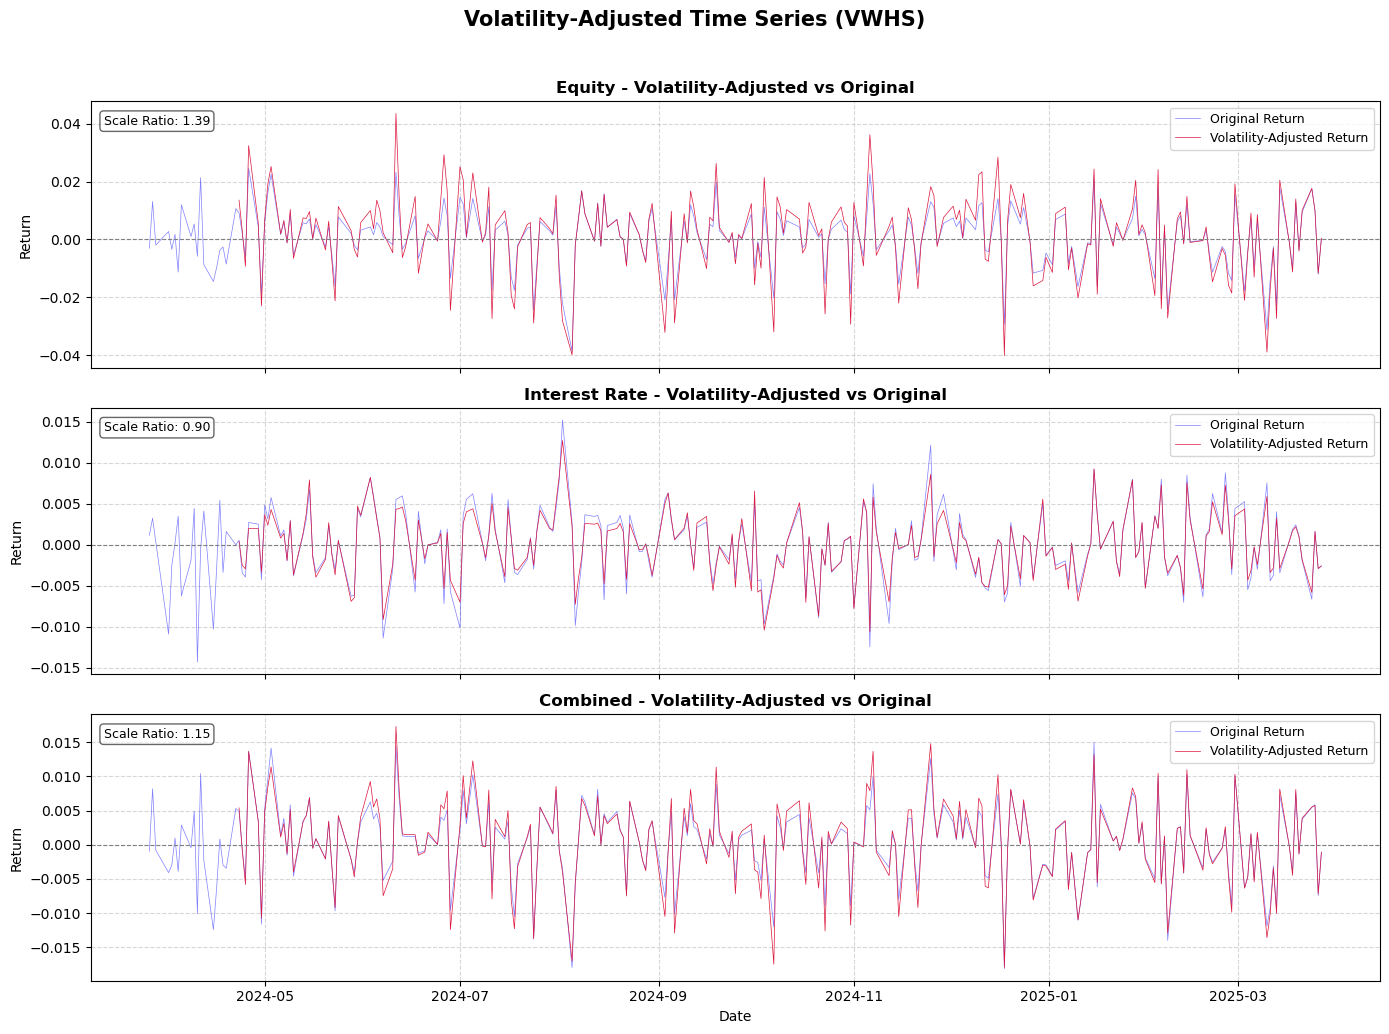


Plot saved as: PORTFOLIO ASSIGNMENT 2/VWHS_Adjusted_Returns.pdf


In [285]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_volatility_adjusted_subplots(data, window=20, last_n_days=250, save_path="PORTFOLIO ASSIGNMENT 2/VWHS_Adjusted_Returns.pdf"):
    portfolios = data.columns
    n_cols = len(portfolios)
    
    fig, axes = plt.subplots(n_cols, 1, figsize=(14, 3.5 * n_cols), sharex=True)

    if n_cols == 1:
        axes = [axes]

    for i, col in enumerate(portfolios):
        r = data[col].dropna()

        # Optional: limit to last N days
        if last_n_days is not None and len(r) > last_n_days:
            r = r[-last_n_days:]

        rolling_vol = r.rolling(window=window).std()
        current_vol = rolling_vol.iloc[-1]
        valid_idx = rolling_vol.dropna().index
        adjusted = r.loc[valid_idx] * (current_vol / rolling_vol.loc[valid_idx])

        # Scaling factor
        avg_past_vol = rolling_vol.loc[valid_idx].mean()
        vol_ratio = current_vol / avg_past_vol

        ax = axes[i]
        ax.plot(r.index, r, label="Original Return", color="blue", alpha=0.5, linewidth=0.5)
        ax.plot(adjusted.index, adjusted, label="Volatility-Adjusted Return", color="crimson", linewidth=0.5)

        ax.set_title(f"{col} - Volatility-Adjusted vs Original", fontsize=12, fontweight='bold')
        ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(loc="upper right", fontsize=9)
        ax.set_ylabel("Return")

        # Annotation for scaling
        ax.text(0.01, 0.95, f"Scale Ratio: {vol_ratio:.2f}",
                transform=ax.transAxes, fontsize=9, color="black", ha="left", va="top",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.6))

    plt.xlabel("Date")
    plt.suptitle("Volatility-Adjusted Time Series (VWHS)", fontsize=15, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()
    print(f"\nPlot saved as: {save_path}")

# === Run Plot ===
plot_volatility_adjusted_subplots(returns_data)


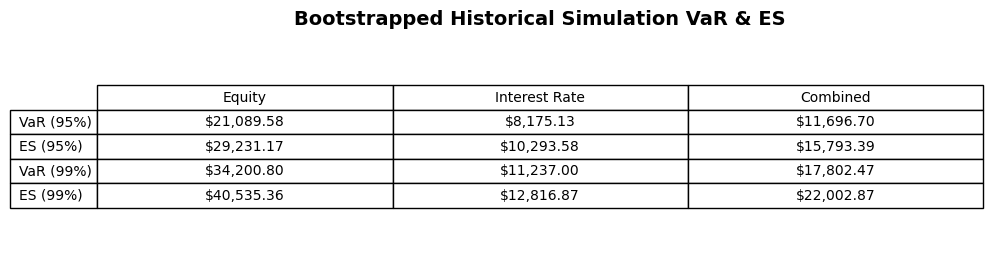


Bootstrapped VaR & ES results saved to:
PORTFOLIO ASSIGNMENT 2/Bootstrapped_VaR_ES.xlsx


In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === PARAMETERS ===
cutoff_date = "2025-03-28"
confidence_levels = [0.95, 0.99]
portfolio_value = 1_000_000
n_bootstrap = 1000
sample_size = 250  # number of returns per bootstrap sample

# === Load Return Data ===
returns_data = portfolio_returns.loc[:cutoff_date].dropna()
portfolios = returns_data.columns.tolist()

# === Helper: Format currency ===
def currency(x):
    return f"${abs(x):,.2f}"

# === Bootstrapped VaR and ES ===
def bootstrap_var_es(r, cl, n_bootstrap=1000, sample_size=250):
    vars_list = []
    es_list = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(r, size=sample_size, replace=True)
        var = np.percentile(sample, (1 - cl) * 100)
        es = sample[sample <= var].mean()
        vars_list.append(var)
        es_list.append(es)
    final_var = np.mean(vars_list)
    final_es = np.mean(es_list)
    return final_var * portfolio_value, final_es * portfolio_value

# === Build Table ===
results = []
for col in portfolios:
    r = returns_data[col].dropna().values
    row = []
    for cl in confidence_levels:
        var, es = bootstrap_var_es(r, cl, n_bootstrap, sample_size)
        row += [currency(var), currency(es)]
    results.append(row)

# === Create DataFrame ===
df_bootstrap = pd.DataFrame(
    results,
    index=portfolios,
    columns=["VaR (95%)", "ES (95%)", "VaR (99%)", "ES (99%)"]
).T

# === Display Table Function ===
def display_table(df, title, figsize=(10, 2.8), scale=(1.1, 1.4)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.title(title, fontsize=14, fontweight="bold")
    table = plt.table(
        cellText=df.values,
        rowLabels=df.index,
        colLabels=df.columns,
        cellLoc="center",
        colLoc="center",
        loc="center"
    )
    table.scale(*scale)
    plt.tight_layout()
    plt.show()

# === Show Table & Save ===
display_table(df_bootstrap, "Bootstrapped Historical Simulation VaR & ES")

# === Save to Excel ===
output_path = "PORTFOLIO ASSIGNMENT 2/Bootstrapped_VaR_ES.xlsx"
df_bootstrap.to_excel(output_path, sheet_name="Bootstrapped VaR ES")
print(f"\nBootstrapped VaR & ES results saved to:\n{output_path}")


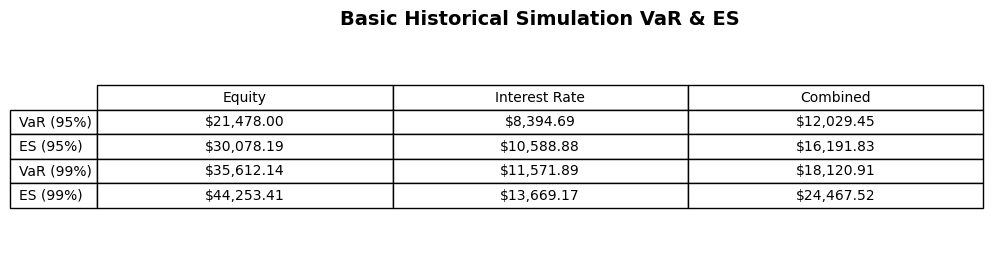


Basic Historical Simulation results saved to:
PORTFOLIO ASSIGNMENT 2/HS_VaR_ES.xlsx


In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === PARAMETERS ===
cutoff_date = "2025-03-28"
confidence_levels = [0.95, 0.99]
portfolio_value = 1_000_000

# === Load Data ===
returns_data = portfolio_returns.loc[:cutoff_date].dropna()
portfolios = returns_data.columns.tolist()

# === Formatting Helper ===
def currency(x):
    return f"${x:,.2f}"

# === Historical Simulation VaR & ES Function ===
def basic_hs_var_es(returns, cl):
    sorted_returns = np.sort(returns)
    index = int((1 - cl) * len(sorted_returns))
    var = -sorted_returns[index]
    es = -sorted_returns[:index].mean() if index > 0 else var  # fallback if index is 0
    return var * portfolio_value, es * portfolio_value

# === Build Table of Results ===
results = []
for col in portfolios:
    r = returns_data[col].dropna()
    row = []
    for cl in confidence_levels:
        var, es = basic_hs_var_es(r, cl)
        row += [currency(var), currency(es)]
    results.append(row)

# === Create DataFrame ===
df_hs = pd.DataFrame(
    results,
    index=portfolios,
    columns=["VaR (95%)", "ES (95%)", "VaR (99%)", "ES (99%)"]
).T

# === Display Table Function ===
def display_table(df, title, figsize=(10, 2.8), scale=(1.1, 1.4)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.title(title, fontsize=14, fontweight="bold")
    table = plt.table(
        cellText=df.values,
        rowLabels=df.index,
        colLabels=df.columns,
        cellLoc='center',
        colLoc='center',
        loc='center'
    )
    table.scale(*scale)
    plt.tight_layout()
    plt.show()

# === Display Table ===
display_table(df_hs, "Basic Historical Simulation VaR & ES")

# === Save to Excel ===
output_path = "PORTFOLIO ASSIGNMENT 2/HS_VaR_ES.xlsx"
df_hs.to_excel(output_path, sheet_name="Historical Simulation")
print(f"\nBasic Historical Simulation results saved to:\n{output_path}")


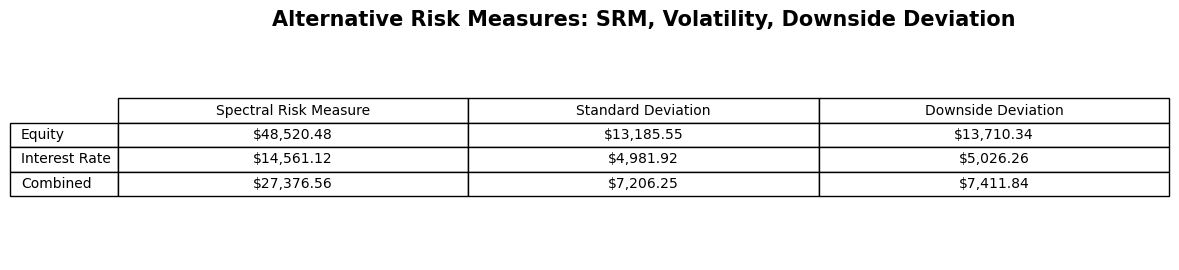


Alternative risk measures saved to:
PORTFOLIO_ASSIGNMENT_2\Alternative_Risk_Measures_SRM.xlsx


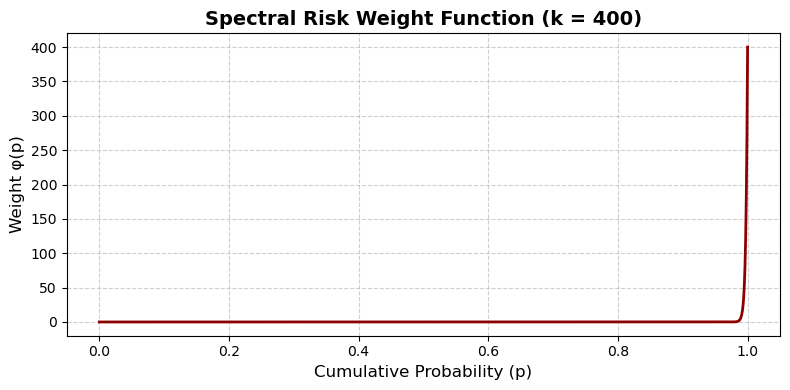

In [291]:
# === Import Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from adjustText import adjust_text

# === PARAMETERS ===
start_date = "2021-03-30"
end_date = "2025-03-28"
cutoff_date = "2025-03-28"
portfolio_value = 1_000_000
risk_aversion_k = 400      # Exponential risk aversion coefficient
n_slices = 10000           # Number of integration slices for SRM
a = 0.0001                 # Start percentile
b = 0.9999                 # End percentile

# === Folder Setup ===
output_folder = "PORTFOLIO_ASSIGNMENT_2"
os.makedirs(output_folder, exist_ok=True)

# === Load Portfolio Returns ===
# Assumes 'portfolio_returns' is already defined elsewhere in your notebook/script
returns_data = portfolio_returns.loc[:cutoff_date].dropna()
portfolios = returns_data.columns.tolist()

# === Helper: Format as currency ===
def currency(x):
    return f"${x:,.2f}"

# === Spectral Weighting Function (Exponential) ===
def phi_exponential(p, k):
    numerator = k * np.exp(-k * (1 - p))
    denominator = 1 - np.exp(-k)
    return numerator / denominator

# === Spectral Risk Measure Function ===
def calculate_srm(returns, k=400, N=10000, a=0.0001, b=0.9999):
    losses = -np.array(returns.dropna())
    ps = np.linspace(a, b, N)
    weighted_losses = np.percentile(losses, ps * 100)
    weights = phi_exponential(ps, k)
    weights /= weights.sum()
    srm = np.dot(weights, weighted_losses)
    return srm * portfolio_value

# === Volatility Function ===
def calculate_volatility(returns):
    return returns.std(ddof=1) * portfolio_value

# === Downside Deviation Function ===
def calculate_downside_deviation(returns):
    downside_returns = returns[returns < 0]
    if downside_returns.empty:
        return 0.0
    return np.sqrt((downside_returns**2).mean()) * portfolio_value

# === Build Risk Table ===
risk_results = []
for col in portfolios:
    r = returns_data[col].dropna()
    srm = calculate_srm(r, k=risk_aversion_k, N=n_slices, a=a, b=b)
    vol = calculate_volatility(r)
    downside = calculate_downside_deviation(r)

    risk_results.append({
        "Portfolio": col,
        "Spectral Risk Measure": currency(srm),
        "Standard Deviation": currency(vol),
        "Downside Deviation": currency(downside)
    })

# === Create DataFrame ===
df_alt_risks = pd.DataFrame(risk_results).set_index("Portfolio")

# === Display Table ===
def display_table(df, title, figsize=(12, 2.8), scale=(1.2, 1.4)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.title(title, fontsize=15, fontweight="bold")
    table = plt.table(
        cellText=df.values,
        rowLabels=df.index,
        colLabels=df.columns,
        cellLoc="center",
        colLoc="center",
        loc="center"
    )
    table.scale(*scale)
    plt.tight_layout()
    plt.show()

# === Show Table ===
display_table(df_alt_risks, "Alternative Risk Measures: SRM, Volatility, Downside Deviation")

# === Save to Excel ===
output_path = os.path.join(output_folder, "Alternative_Risk_Measures_SRM.xlsx")
df_alt_risks.to_excel(output_path)
print(f"\nAlternative risk measures saved to:\n{output_path}")

# === Plot SRM Weighting Function ===
def plot_srm_weighting_function(k=400):
    ps = np.linspace(0, 1, 1000)
    weights = phi_exponential(ps, k)

    plt.figure(figsize=(8, 4))
    plt.plot(ps, weights, color='darkred', linewidth=2)
    plt.title(f"Spectral Risk Weight Function (k = {k})", fontsize=14, fontweight="bold")
    plt.xlabel("Cumulative Probability (p)", fontsize=12)
    plt.ylabel("Weight φ(p)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# === Show Weight Function Plot ===
plot_srm_weighting_function(k=risk_aversion_k)


Rolling Window Size for Equity Portfolio: 499 observations

Running Backtests for Equity Portfolio...

Backtesting: Normal Distribution
Backtesting: Student-t Distribution
Backtesting: Cornish-Fisher Expansion
Backtesting: Monte Carlo Normal
Backtesting: Monte Carlo Student-t
Backtesting: Historical Simulation
Backtesting: Bootstrap Historical Simulation
Backtesting: Age-Weighted Historical Simulation
Backtesting: Volatility-Weighted Historical Simulation

Final Backtest Results for Equity Portfolio:


Estimation Sample Size  \
Model                                                               
Normal Distribution                                           500   
Student-t Distribution                                        500   
Cornish-Fisher Expansion                                      500   
Monte Carlo Normal                                            500   
Monte Carlo Student-t                                         500   
Historical Simulation                                         500   
Bootstrap Historical Simulation                               500   
Age-Weighted Historical Simulation                            500   
Volatility-Weighted Historical Simulation                     500   

                                           Out-of-Sample Size  \
Model                                                           
Normal Distribution                                       497   
Student-t Distribution                                    497   
Cornish-Fisher Expansion                                  497   
Monte Carlo Normal                                        497   
Monte Carlo Student-t                                     497   
Historical Simulation                                     497   
Bootstrap Historical Simulation                           497   
Age-Weighted Historical Simulation                        497   
Volatility-Weighted Historical Simulation                 497   

                                           Expected Breaches  \
Model                                                          
Normal Distribution                                    24.85   
Student-t Distribution                                 24.85   
Cornish-Fisher Expansion                               24.85   
Monte Carlo Normal                                     24.85   
Monte Carlo Student-t                                  24.85   
Historical Simulation                                  24.85   
Bootstrap Historical Simulation                        24.85   
Age-Weighted Historical Simulation                     24.85   
Volatility-Weighted Historical Simulation              24.85   

                                           Observed Breaches  Kupiec p-value  \
Model                                                                          
Normal Distribution                                       17          0.9407   
Student-t Distribution                                    17          0.9407   
Cornish-Fisher Expansion                                  17          0.9407   
Monte Carlo Normal                                        17          0.9407   
Monte Carlo Student-t                                     17          0.9407   
Historical Simulation                                     15          0.9787   
Bootstrap Historical Simulation                           14          0.9884   
Age-Weighted Historical Simulation                        35          0.0181   
Volatility-Weighted Historical Simulation                 35          0.0181   

                                          Kupiec Test   LR_uc  QPS Score  \
Model                                                                      
Normal Distribution                            Accept  2.9219     0.0666   
Student-t Distribution                         Accept  2.9219     0.0666   
Cornish-Fisher Expansion                       Accept  2.9219     0.0666   
Monte Carlo Normal                             Accept  2.9219     0.0666   
Monte Carlo Student-t                          Accept  2.9219     0.0666   
Historical Simulation                          Accept  4.7599     0.0593   
Bootstrap Historical Simulation                Accept  5.8810     0.0557   
Age-Weighted Historical Simulation             Reject  3.8941     0.1318   
Volatility-Weighted Historical Simulation      Reject  3.8941     0.1318   

                                          Basel Zone  
Model                                                 
Normal Distribution               


 Saved to: PORTFOLIO ASSIGNMENT 2/Backtesting_Equity_Final.xlsx


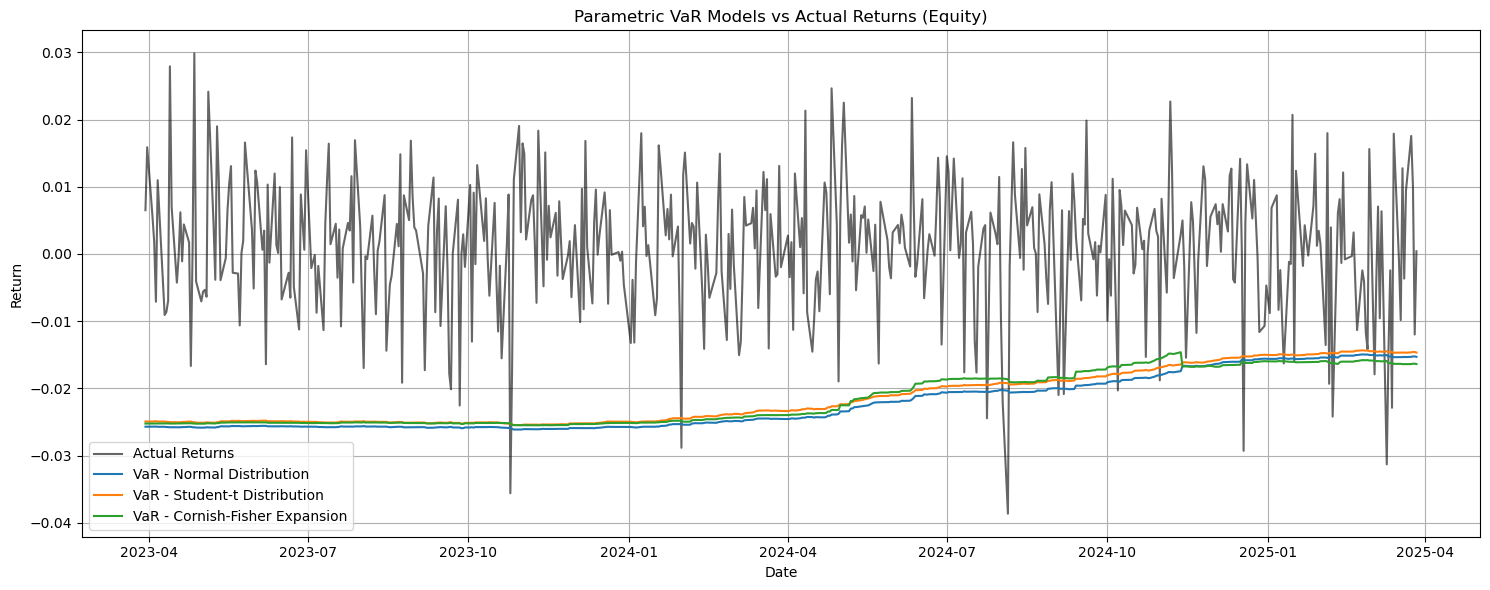

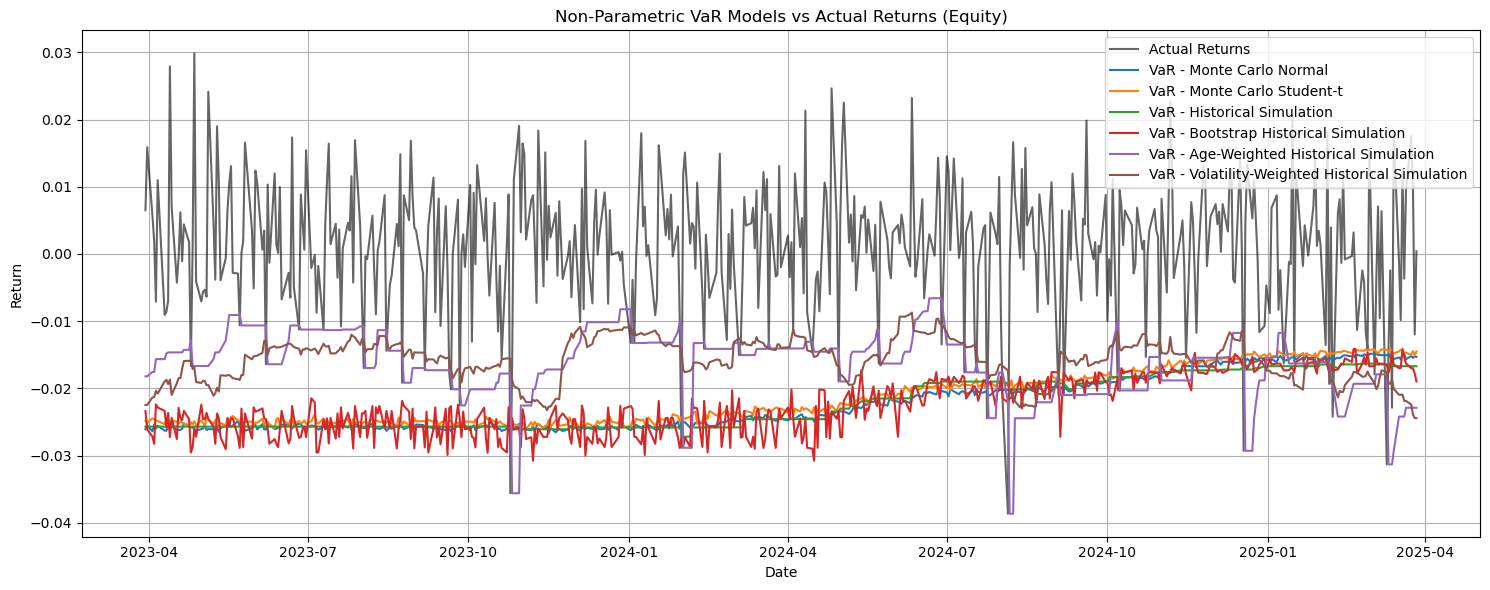

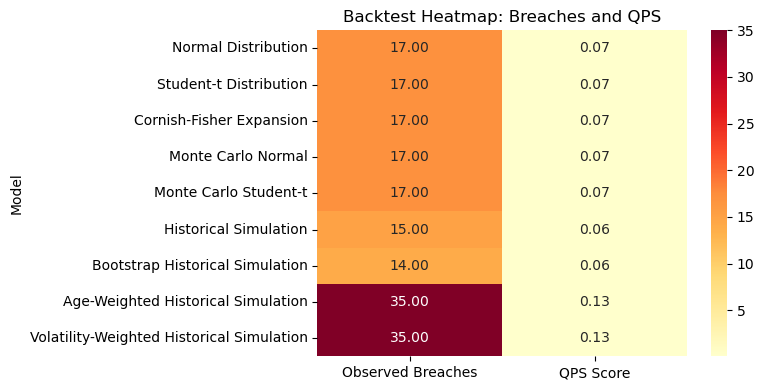

In [293]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom, norm, t

# === PARAMETERS ===
estimation_start = "2021-03-30"
estimation_end = "2023-03-29"
test_start = "2023-03-30"
test_end = "2025-03-28"
alpha = 0.05  # VaR confidence level
portfolio_value = 1_000_000
output_folder = "PORTFOLIO ASSIGNMENT 2"

# === Load Return Data ===
returns_equity = portfolio_returns['Equity'].dropna()
returns_equity = returns_equity.loc[:test_end]

# === Rolling window size ===
window_size = returns_equity.loc[estimation_start:estimation_end].shape[0]
print(f"Rolling Window Size for Equity Portfolio: {window_size} observations")

# === VaR Model Definitions ===
def historical_var(r, a): return np.percentile(r, 100 * a)
def bootstrap_var(r, a): return np.percentile(np.random.choice(r, size=len(r), replace=True), 100 * a)
def age_weighted_var(r, a, lam=0.94):
    n = len(r)
    weights = np.array([(1 - lam) * lam**i for i in range(n)][::-1])
    weights /= weights.sum()
    sorted_r = np.sort(r)
    cum_w = np.cumsum(weights[np.argsort(r)])
    idx = np.searchsorted(cum_w, a)
    return sorted_r[idx]
def volatility_weighted_var(r, a):
    vol = r.rolling(window=20).std().bfill()
    adj = r / vol
    current_vol = r.iloc[-1] / adj.iloc[-1]
    sim = adj * current_vol
    return np.percentile(sim, 100 * a)
def normal_var(r, a):
    mu, sigma = r.mean(), r.std()
    return norm.ppf(a, loc=mu, scale=sigma)
def cornish_fisher_var(r, a):
    mu, sigma = r.mean(), r.std()
    skew = r.skew(); kurt = r.kurtosis(); z = norm.ppf(a)
    z_cf = z + (1/6)*(z**2 - 1)*skew + (1/24)*(z**3 - 3*z)*kurt - (1/36)*(2*z**3 - 5*z)*(skew**2)
    return mu + sigma * z_cf
def student_t_var(r, a):
    df, loc, scale = t.fit(r)
    return t.ppf(a, df, loc=loc, scale=scale)
def mc_normal_var(r, a):
    mu, sigma = r.mean(), r.std()
    sims = np.random.normal(mu, sigma, 10000)
    return np.percentile(sims, 100 * a)
def mc_t_var(r, a):
    df, loc, scale = t.fit(r)
    sims = t.rvs(df, loc=loc, scale=scale, size=10000)
    return np.percentile(sims, 100 * a)

# === Backtesting Engine ===
def backtest_model(returns, model_func, alpha, window_size):
    test_returns = returns.loc[test_start:test_end]
    rolling_window = returns.loc[estimation_start:estimation_end].copy()

    var_list = []
    for idx in test_returns.index:
        if len(rolling_window) > window_size:
            rolling_window = rolling_window.iloc[-window_size:]
        var = model_func(rolling_window, alpha)
        var_list.append(var if not np.isnan(var) else np.nan)
        rolling_window = pd.concat([rolling_window, test_returns.loc[[idx]]])

    var_series = pd.Series(var_list, index=test_returns.index)
    valid_idx = ~var_series.isna()
    breaches = test_returns[valid_idx] < var_series[valid_idx]
    observed = breaches.sum()
    expected = len(breaches) * alpha

    # Kupiec test
    p_hat = observed / len(breaches)
    LR_uc = -2 * (np.log((1 - alpha)**(len(breaches) - observed) * (alpha)**observed) -
                  np.log((1 - p_hat)**(len(breaches) - observed) * (p_hat)**observed))
    kupiec_p = 1 - binom.cdf(observed, len(breaches), alpha)
    kupiec_hypothesis = "Accept" if kupiec_p > 0.05 else "Reject"

    # Basel Traffic Light
    if observed <= expected + 4:
        traffic_zone = "Green"
    elif observed <= expected + 9:
        traffic_zone = "Yellow"
    else:
        traffic_zone = "Red"

    # QPS
    hits = breaches.astype(int)
    QPS = (2 * (hits - alpha)**2).mean()

    return len(rolling_window), len(breaches), expected, observed, kupiec_p, kupiec_hypothesis, LR_uc, QPS, traffic_zone, var_series

# === Models ===
models = {
    "Normal Distribution": normal_var,
    "Student-t Distribution": student_t_var,
    "Cornish-Fisher Expansion": cornish_fisher_var,
    "Monte Carlo Normal": mc_normal_var,
    "Monte Carlo Student-t": mc_t_var,
    "Historical Simulation": historical_var,
    "Bootstrap Historical Simulation": bootstrap_var,
    "Age-Weighted Historical Simulation": age_weighted_var,
    "Volatility-Weighted Historical Simulation": volatility_weighted_var,
}

# === Run All Models ===
results = []
var_series_dict = {}

print("\nRunning Backtests for Equity Portfolio...\n")
for name, func in models.items():
    print(f"Backtesting: {name}")
    n_in, n_out, expected, observed, kupiec_p, kupiec_hyp, LR_uc, QPS, zone, var_series = backtest_model(
        returns_equity, func, alpha, window_size
    )
    results.append({
        "Model": name,
        "Estimation Sample Size": n_in,
        "Out-of-Sample Size": n_out,
        "Expected Breaches": round(expected, 2),
        "Observed Breaches": observed,
        "Kupiec p-value": round(kupiec_p, 4),
        "Kupiec Test": kupiec_hyp,
        "LR_uc": round(LR_uc, 4),
        "QPS Score": round(QPS, 4),
        "Basel Zone": zone
    })
    var_series_dict[name] = var_series

# === Final DataFrame ===
df_backtest = pd.DataFrame(results).set_index("Model")
print("\nFinal Backtest Results for Equity Portfolio:")
display(df_backtest)

# === Save to Excel ===
df_backtest.to_excel(f"{output_folder}/Backtesting_Equity_Final.xlsx")
print(f"\n Saved to: {output_folder}/Backtesting_Equity_Final.xlsx")

# === Save Plots ===
parametric = [k for k in models if "Monte Carlo" not in k and "Historical" not in k]
nonparametric = [k for k in models if "Historical" in k or "Monte Carlo" in k]

# Parametric Plot
plt.figure(figsize=(15, 6))
plt.plot(returns_equity.loc[test_start:test_end], label="Actual Returns", color='black', alpha=0.6)
for model in parametric:
    plt.plot(var_series_dict[model], label=f"VaR - {model}")
plt.title("Parametric VaR Models vs Actual Returns (Equity)")
plt.xlabel("Date"); plt.ylabel("Return"); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_folder}/VaR_Chart_Parametric.png", dpi=300)
plt.show()

# Non-Parametric Plot
plt.figure(figsize=(15, 6))
plt.plot(returns_equity.loc[test_start:test_end], label="Actual Returns", color='black', alpha=0.6)
for model in nonparametric:
    plt.plot(var_series_dict[model], label=f"VaR - {model}")
plt.title("Non-Parametric VaR Models vs Actual Returns (Equity)")
plt.xlabel("Date"); plt.ylabel("Return"); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_folder}/VaR_Chart_NonParametric.png", dpi=300)
plt.show()

# === Optional: Heatmap of Breaches and QPS ===
plt.figure(figsize=(8, 4))
sns.heatmap(df_backtest[["Observed Breaches", "QPS Score"]], annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("Backtest Heatmap: Breaches and QPS")
plt.tight_layout()
plt.savefig(f"{output_folder}/Backtest_Heatmap_QPS.png", dpi=300)
plt.show()


Rolling Window Size for Interest Rate Portfolio: 499 observations

Running Backtests for Interest Rate Portfolio...

Running Normal Distribution...
Running Student-t Distribution...
Running Cornish-Fisher Expansion...
Running Monte Carlo Normal...
Running Monte Carlo Student-t...
Running Historical Simulation...
Running Bootstrap Historical Simulation...
Running Age-Weighted Historical Simulation...
Running Volatility-Weighted Historical Simulation...

Final Backtest Results for Interest Rate Portfolio:


Estimation Sample Size  \
Model                                                               
Normal Distribution                                           500   
Student-t Distribution                                        500   
Cornish-Fisher Expansion                                      500   
Monte Carlo Normal                                            500   
Monte Carlo Student-t                                         500   
Historical Simulation                                         500   
Bootstrap Historical Simulation                               500   
Age-Weighted Historical Simulation                            500   
Volatility-Weighted Historical Simulation                     500   

                                           Out-of-Sample Size  \
Model                                                           
Normal Distribution                                       497   
Student-t Distribution                                    497   
Cornish-Fisher Expansion                                  497   
Monte Carlo Normal                                        497   
Monte Carlo Student-t                                     497   
Historical Simulation                                     497   
Bootstrap Historical Simulation                           497   
Age-Weighted Historical Simulation                        497   
Volatility-Weighted Historical Simulation                 495   

                                           Expected Breaches  \
Model                                                          
Normal Distribution                                    24.85   
Student-t Distribution                                 24.85   
Cornish-Fisher Expansion                               24.85   
Monte Carlo Normal                                     24.85   
Monte Carlo Student-t                                  24.85   
Historical Simulation                                  24.85   
Bootstrap Historical Simulation                        24.85   
Age-Weighted Historical Simulation                     24.85   
Volatility-Weighted Historical Simulation              24.75   

                                           Observed Breaches  Kupiec p-value  \
Model                                                                          
Normal Distribution                                       22          0.6771   
Student-t Distribution                                    21          0.7496   
Cornish-Fisher Expansion                                  23          0.5983   
Monte Carlo Normal                                        21          0.7496   
Monte Carlo Student-t                                     22          0.6771   
Historical Simulation                                     23          0.5983   
Bootstrap Historical Simulation                           19          0.8665   
Age-Weighted Historical Simulation                        29          0.1683   
Volatility-Weighted Historical Simulation                 31          0.0857   

                                          Kupiec Test   LR_uc  QPS Score  \
Model                                                                      
Normal Distribution                            Accept  0.3573     0.0847   
Student-t Distribution                         Accept  0.6612     0.0811   
Cornish-Fisher Expansion                       Accept  0.1485     0.0883   
Monte Carlo Normal                             Accept  0.6612     0.0811   
Monte Carlo Student-t                          Accept  0.3573     0.0847   
Historical Simulation                          Accept  0.1485     0.0883   
Bootstrap Historical Simulation                Accept  1.5723     0.0738   
Age-Weighted Historical Simulation             Accept  0.6940     0.1100   
Volatility-Weighted Historical Simulation      Accept  1.5435     0.1177   

                                          Basel Zone  
Model                                                 
Normal Distribution               


 Saved to: PORTFOLIO ASSIGNMENT 2/Backtesting_InterestRate_Final.xlsx


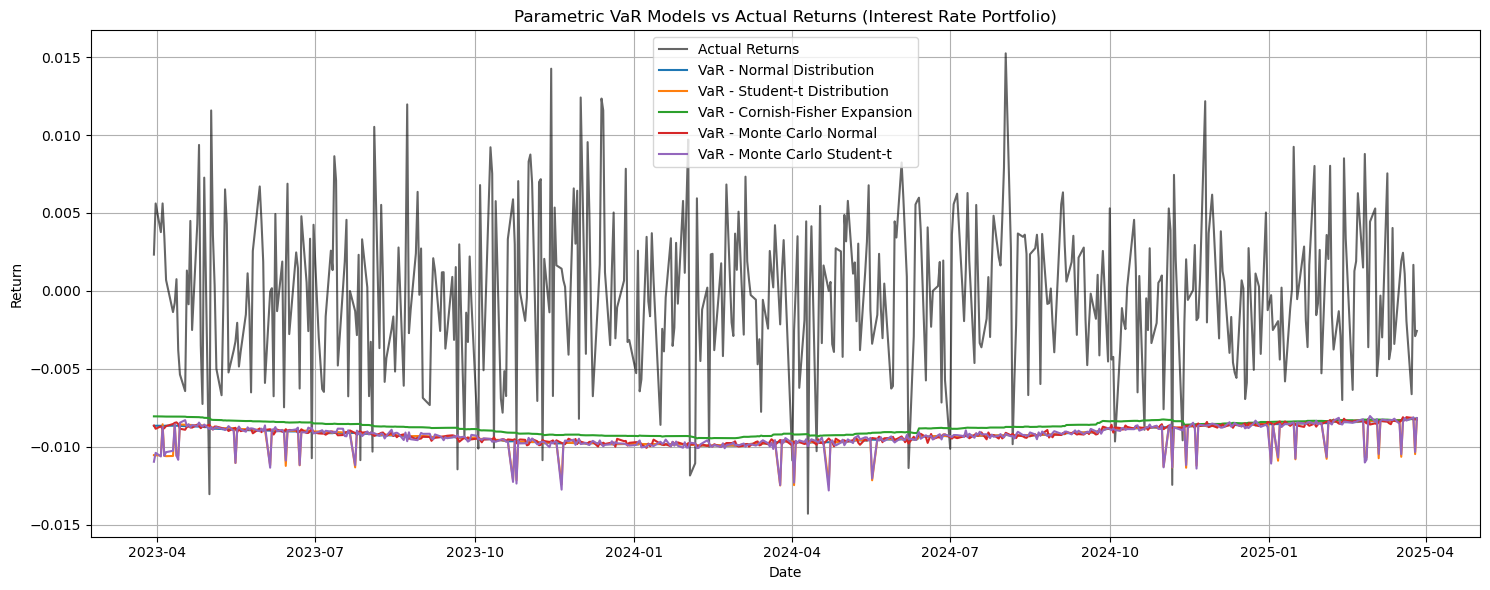

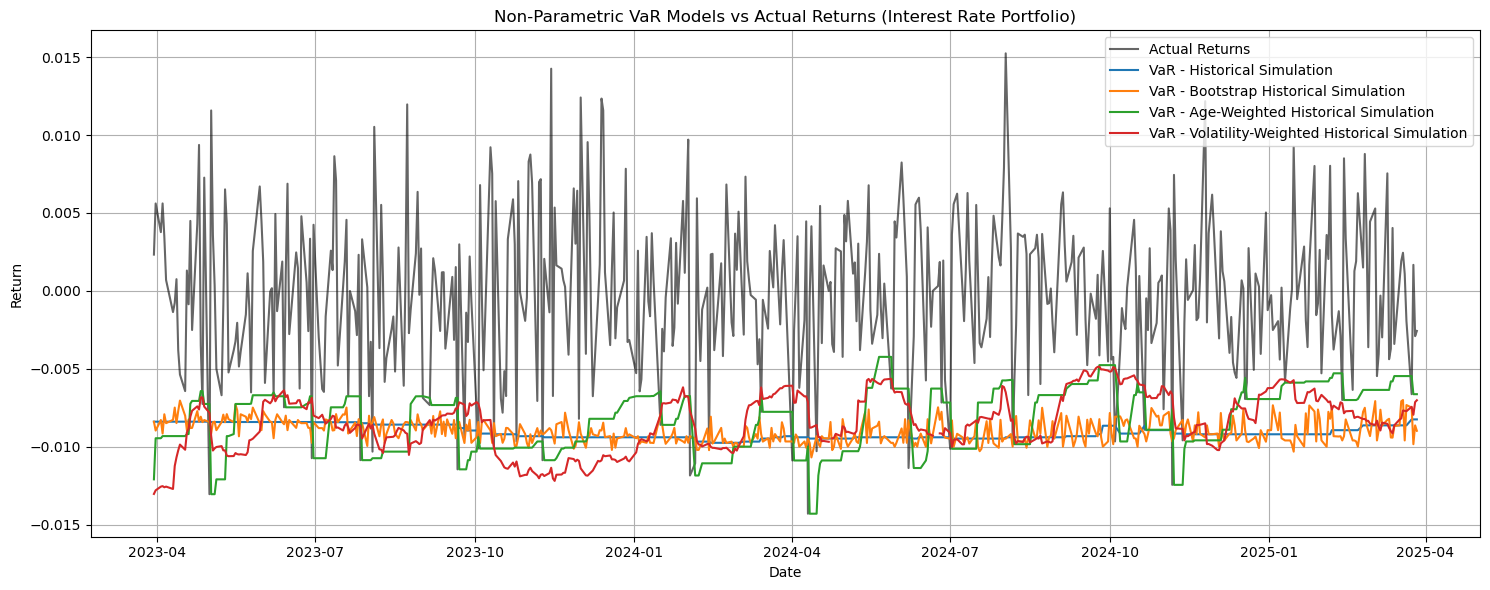

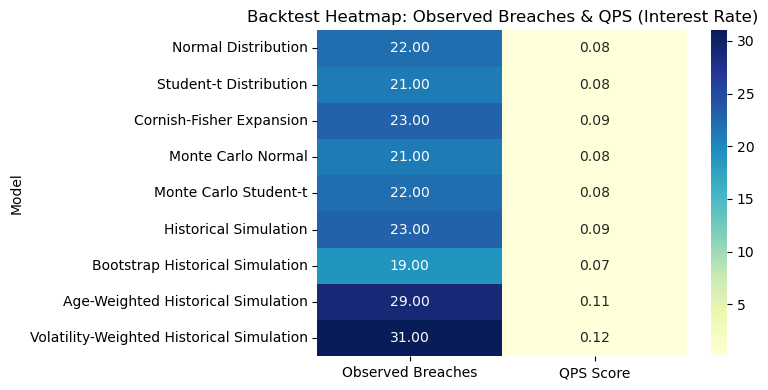

In [295]:
# === Import Libraries (if not already imported) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom, norm, t

# === PARAMETERS ===
estimation_start = "2021-03-30"
estimation_end = "2023-03-29"
test_start = "2023-03-30"
test_end = "2025-03-28"
alpha = 0.05  # 95% confidence level
output_folder = "PORTFOLIO ASSIGNMENT 2"

# === Load Interest Rate Portfolio Returns ===
returns_interest = portfolio_returns['Interest Rate'].dropna()
returns_interest = returns_interest.loc[:test_end]

# === Rolling Window Size ===
window_size = returns_interest.loc[estimation_start:estimation_end].shape[0]
print(f"Rolling Window Size for Interest Rate Portfolio: {window_size} observations")

# === Backtest Function (must already exist) ===
# backtest_model(returns, model_func, alpha, window_size)

# === VaR Models (must already be defined) ===
models = {
    "Normal Distribution": normal_var,
    "Student-t Distribution": student_t_var,
    "Cornish-Fisher Expansion": cornish_fisher_var,
    "Monte Carlo Normal": mc_normal_var,
    "Monte Carlo Student-t": mc_t_var,
    "Historical Simulation": historical_var,
    "Bootstrap Historical Simulation": bootstrap_var,
    "Age-Weighted Historical Simulation": age_weighted_var,
    "Volatility-Weighted Historical Simulation": volatility_weighted_var,
}

# === Backtesting Loop ===
results_ir = []
var_series_ir_dict = {}

print("\nRunning Backtests for Interest Rate Portfolio...\n")
for model_name, model_func in models.items():
    print(f"Running {model_name}...")
    n_in, n_out, expected, observed, kupiec_p, kupiec_hyp, LR_uc, QPS, zone, var_series = backtest_model(
        returns_interest, model_func, alpha, window_size
    )
    results_ir.append({
        "Model": model_name,
        "Estimation Sample Size": n_in,
        "Out-of-Sample Size": n_out,
        "Expected Breaches": round(expected, 2),
        "Observed Breaches": observed,
        "Kupiec p-value": round(kupiec_p, 4),
        "Kupiec Test": kupiec_hyp,
        "LR_uc": round(LR_uc, 4),
        "QPS Score": round(QPS, 4),
        "Basel Zone": zone
    })
    var_series_ir_dict[model_name] = var_series

# === Result DataFrame ===
df_backtest_ir = pd.DataFrame(results_ir).set_index("Model")
print("\nFinal Backtest Results for Interest Rate Portfolio:")
display(df_backtest_ir)

# === Save to Excel ===
output_path = f"{output_folder}/Backtesting_InterestRate_Final.xlsx"
df_backtest_ir.to_excel(output_path)
print(f"\n Saved to: {output_path}")

# === Save VaR Plots ===
parametric_models = [
    "Normal Distribution", "Student-t Distribution", "Cornish-Fisher Expansion",
    "Monte Carlo Normal", "Monte Carlo Student-t"
]
nonparametric_models = [
    "Historical Simulation", "Bootstrap Historical Simulation",
    "Age-Weighted Historical Simulation", "Volatility-Weighted Historical Simulation"
]

# === Parametric Plot ===
plt.figure(figsize=(15, 6))
plt.plot(returns_interest.loc[test_start:test_end], label="Actual Returns", color='black', alpha=0.6)
for model in parametric_models:
    plt.plot(var_series_ir_dict[model], label=f"VaR - {model}")
plt.title("Parametric VaR Models vs Actual Returns (Interest Rate Portfolio)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_folder}/VaR_Chart_Parametric_InterestRate.png", dpi=300)
plt.show()

# === Non-Parametric Plot ===
plt.figure(figsize=(15, 6))
plt.plot(returns_interest.loc[test_start:test_end], label="Actual Returns", color='black', alpha=0.6)
for model in nonparametric_models:
    plt.plot(var_series_ir_dict[model], label=f"VaR - {model}")
plt.title("Non-Parametric VaR Models vs Actual Returns (Interest Rate Portfolio)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_folder}/VaR_Chart_NonParametric_InterestRate.png", dpi=300)
plt.show()

# === Optional: Heatmap ===
plt.figure(figsize=(8, 4))
sns.heatmap(df_backtest_ir[["Observed Breaches", "QPS Score"]], annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Backtest Heatmap: Observed Breaches & QPS (Interest Rate)")
plt.tight_layout()
plt.savefig(f"{output_folder}/Backtest_Heatmap_InterestRate.png", dpi=300)
plt.show()


Rolling Window Size for Combined Portfolio: 499 observations

Running Backtests for Combined Portfolio...

Running Normal Distribution...
Running Student-t Distribution...
Running Cornish-Fisher Expansion...
Running Monte Carlo Normal...
Running Monte Carlo Student-t...
Running Historical Simulation...
Running Bootstrap Historical Simulation...
Running Age-Weighted Historical Simulation...
Running Volatility-Weighted Historical Simulation...

Final Backtest Results for Combined Portfolio:


Estimation Sample Size  \
Model                                                               
Normal Distribution                                           500   
Student-t Distribution                                        500   
Cornish-Fisher Expansion                                      500   
Monte Carlo Normal                                            500   
Monte Carlo Student-t                                         500   
Historical Simulation                                         500   
Bootstrap Historical Simulation                               500   
Age-Weighted Historical Simulation                            500   
Volatility-Weighted Historical Simulation                     500   

                                           Out-of-Sample Size  \
Model                                                           
Normal Distribution                                       497   
Student-t Distribution                                    497   
Cornish-Fisher Expansion                                  497   
Monte Carlo Normal                                        497   
Monte Carlo Student-t                                     497   
Historical Simulation                                     497   
Bootstrap Historical Simulation                           497   
Age-Weighted Historical Simulation                        497   
Volatility-Weighted Historical Simulation                 497   

                                           Expected Breaches  \
Model                                                          
Normal Distribution                                    24.85   
Student-t Distribution                                 24.85   
Cornish-Fisher Expansion                               24.85   
Monte Carlo Normal                                     24.85   
Monte Carlo Student-t                                  24.85   
Historical Simulation                                  24.85   
Bootstrap Historical Simulation                        24.85   
Age-Weighted Historical Simulation                     24.85   
Volatility-Weighted Historical Simulation              24.85   

                                           Observed Breaches  Kupiec p-value  \
Model                                                                          
Normal Distribution                                       12          0.9972   
Student-t Distribution                                    12          0.9972   
Cornish-Fisher Expansion                                  15          0.9787   
Monte Carlo Normal                                        12          0.9972   
Monte Carlo Student-t                                     12          0.9972   
Historical Simulation                                      9          0.9998   
Bootstrap Historical Simulation                           11          0.9987   
Age-Weighted Historical Simulation                        31          0.0891   
Volatility-Weighted Historical Simulation                 29          0.1683   

                                          Kupiec Test    LR_uc  QPS Score  \
Model                                                                       
Normal Distribution                            Accept   8.5758     0.0485   
Student-t Distribution                         Accept   8.5758     0.0485   
Cornish-Fisher Expansion                       Accept   4.7599     0.0593   
Monte Carlo Normal                             Accept   8.5758     0.0485   
Monte Carlo Student-t                          Accept   8.5758     0.0485   
Historical Simulation                          Accept  13.9448     0.0376   
Bootstrap Historical Simulation                Accept  10.1732     0.0448   
Age-Weighted Historical Simulation             Accept   1.4905     0.1173   
Volatility-Weighted Historical Simulation      Accept   0.6940     0.1100   

                                          Basel Zone  
Model                                                 
Normal Distribution    


Saved to: PORTFOLIO ASSIGNMENT 2/Backtesting_Combined_Final.xlsx


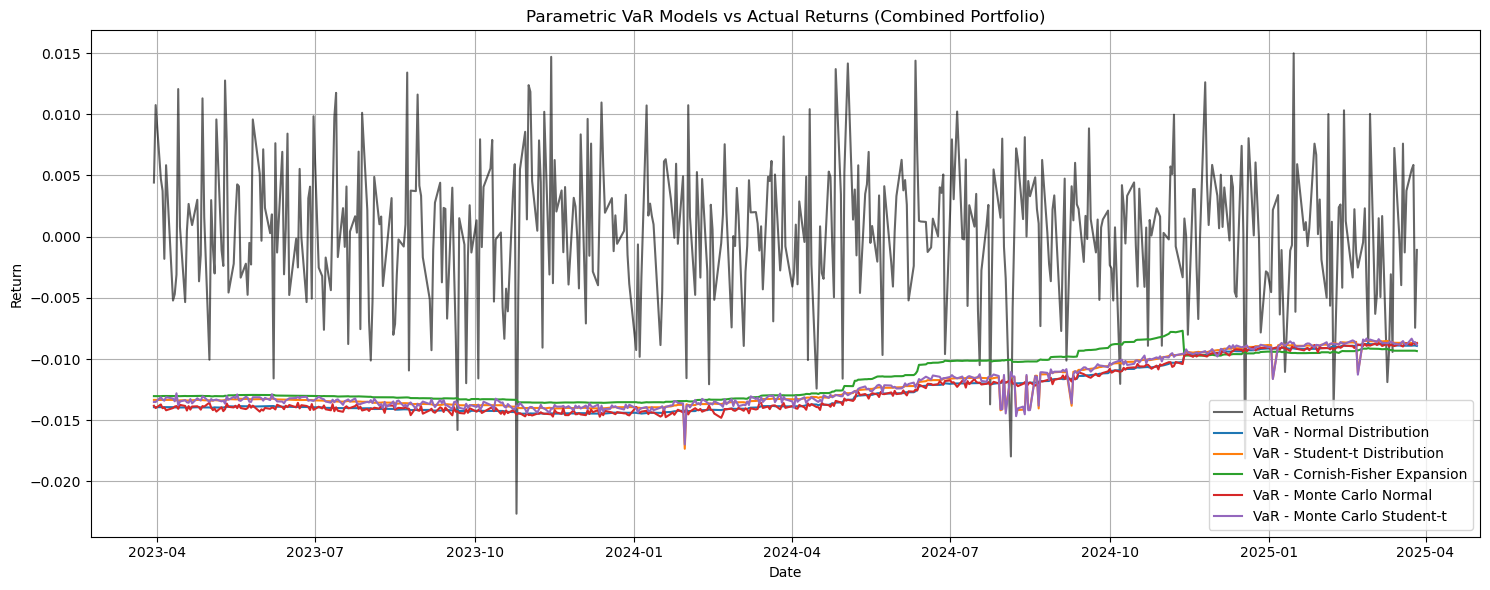

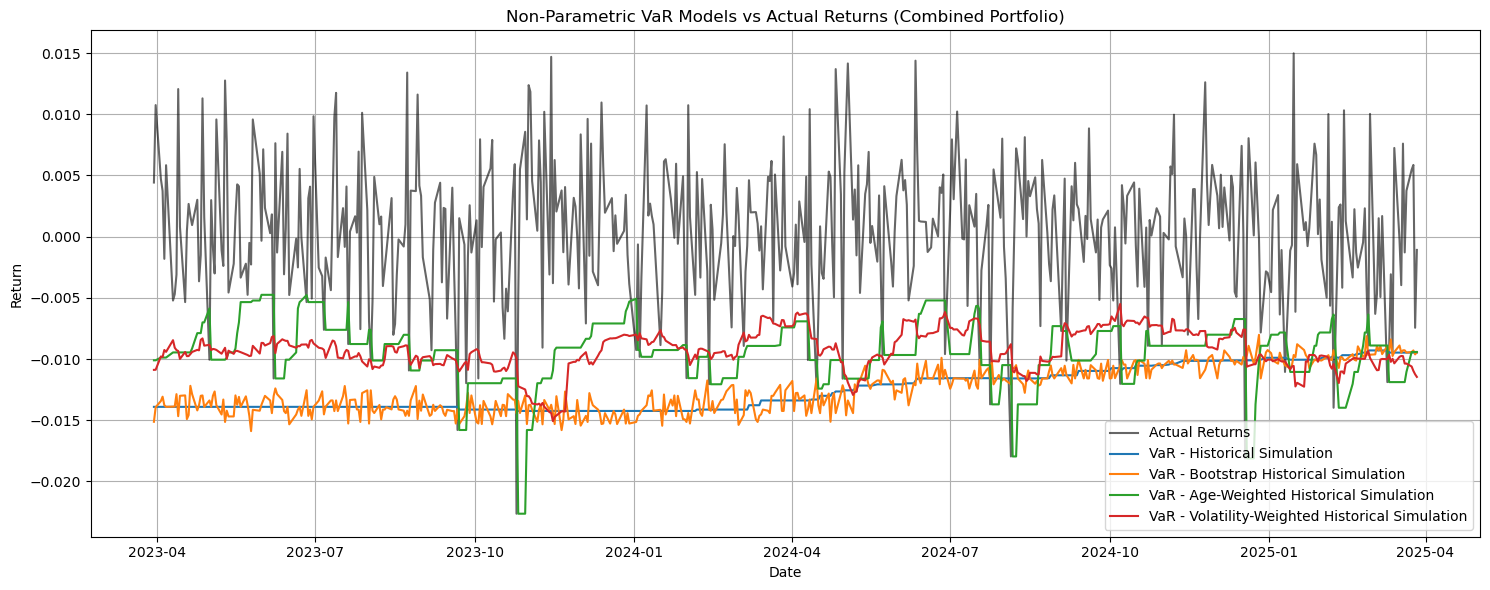

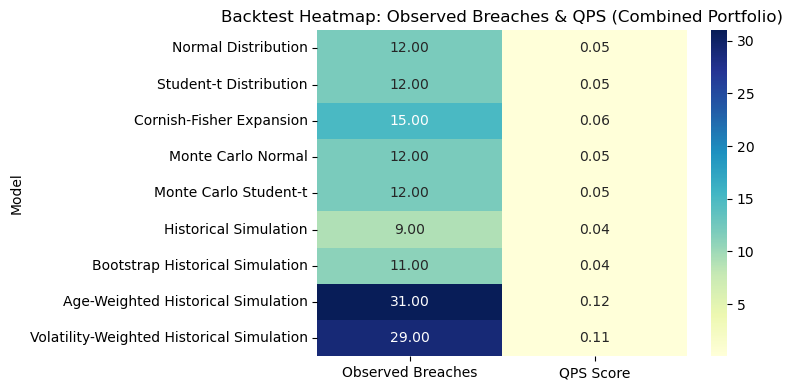

In [297]:
# === Import Libraries (if not already imported) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom, norm, t

# === PARAMETERS ===
estimation_start = "2021-03-30"
estimation_end = "2023-03-29"
test_start = "2023-03-30"
test_end = "2025-03-28"
alpha = 0.05
output_folder = "PORTFOLIO ASSIGNMENT 2"

# === Load Combined Portfolio Returns ===
returns_combined = portfolio_returns['Combined'].dropna()
returns_combined = returns_combined.loc[:test_end]

# === Rolling Window Size ===
window_size = returns_combined.loc[estimation_start:estimation_end].shape[0]
print(f"Rolling Window Size for Combined Portfolio: {window_size} observations")

# === Ensure Required Functions Are Already Defined:
# - normal_var, student_t_var, cornish_fisher_var
# - mc_normal_var, mc_t_var, historical_var, bootstrap_var
# - age_weighted_var, volatility_weighted_var
# - backtest_model with Basel zone and QPS

# === VaR Models Dictionary ===
models = {
    "Normal Distribution": normal_var,
    "Student-t Distribution": student_t_var,
    "Cornish-Fisher Expansion": cornish_fisher_var,
    "Monte Carlo Normal": mc_normal_var,
    "Monte Carlo Student-t": mc_t_var,
    "Historical Simulation": historical_var,
    "Bootstrap Historical Simulation": bootstrap_var,
    "Age-Weighted Historical Simulation": age_weighted_var,
    "Volatility-Weighted Historical Simulation": volatility_weighted_var,
}

# === Backtest Each Model ===
results_combined = []
var_series_combined_dict = {}

print("\nRunning Backtests for Combined Portfolio...\n")
for model_name, model_func in models.items():
    print(f"Running {model_name}...")
    n_in, n_out, expected, observed, kupiec_p, kupiec_hyp, LR_uc, QPS, zone, var_series = backtest_model(
        returns_combined, model_func, alpha, window_size
    )
    results_combined.append({
        "Model": model_name,
        "Estimation Sample Size": n_in,
        "Out-of-Sample Size": n_out,
        "Expected Breaches": round(expected, 2),
        "Observed Breaches": observed,
        "Kupiec p-value": round(kupiec_p, 4),
        "Kupiec Test": kupiec_hyp,
        "LR_uc": round(LR_uc, 4),
        "QPS Score": round(QPS, 4),
        "Basel Zone": zone
    })
    var_series_combined_dict[model_name] = var_series

# === Final DataFrame ===
df_backtest_combined = pd.DataFrame(results_combined).set_index("Model")
print("\nFinal Backtest Results for Combined Portfolio:")
display(df_backtest_combined)

# === Save to Excel ===
output_path = f"{output_folder}/Backtesting_Combined_Final.xlsx"
df_backtest_combined.to_excel(output_path)
print(f"\nSaved to: {output_path}")

# === Save Parametric VaR Plot ===
parametric_models = [
    "Normal Distribution", "Student-t Distribution", "Cornish-Fisher Expansion",
    "Monte Carlo Normal", "Monte Carlo Student-t"
]
nonparametric_models = [
    "Historical Simulation", "Bootstrap Historical Simulation",
    "Age-Weighted Historical Simulation", "Volatility-Weighted Historical Simulation"
]

plt.figure(figsize=(15, 6))
plt.plot(returns_combined.loc[test_start:test_end], label="Actual Returns", color='black', alpha=0.6)
for model in parametric_models:
    plt.plot(var_series_combined_dict[model], label=f"VaR - {model}")
plt.title("Parametric VaR Models vs Actual Returns (Combined Portfolio)")
plt.xlabel("Date"); plt.ylabel("Return")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(f"{output_folder}/VaR_Chart_Parametric_Combined.png", dpi=300)
plt.show()

# === Save Non-Parametric VaR Plot ===
plt.figure(figsize=(15, 6))
plt.plot(returns_combined.loc[test_start:test_end], label="Actual Returns", color='black', alpha=0.6)
for model in nonparametric_models:
    plt.plot(var_series_combined_dict[model], label=f"VaR - {model}")
plt.title("Non-Parametric VaR Models vs Actual Returns (Combined Portfolio)")
plt.xlabel("Date"); plt.ylabel("Return")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(f"{output_folder}/VaR_Chart_NonParametric_Combined.png", dpi=300)
plt.show()

# === Save Heatmap of Breaches and QPS ===
plt.figure(figsize=(8, 4))
sns.heatmap(df_backtest_combined[["Observed Breaches", "QPS Score"]], annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Backtest Heatmap: Observed Breaches & QPS (Combined Portfolio)")
plt.tight_layout()
plt.savefig(f"{output_folder}/Backtest_Heatmap_Combined.png", dpi=300)
plt.show()


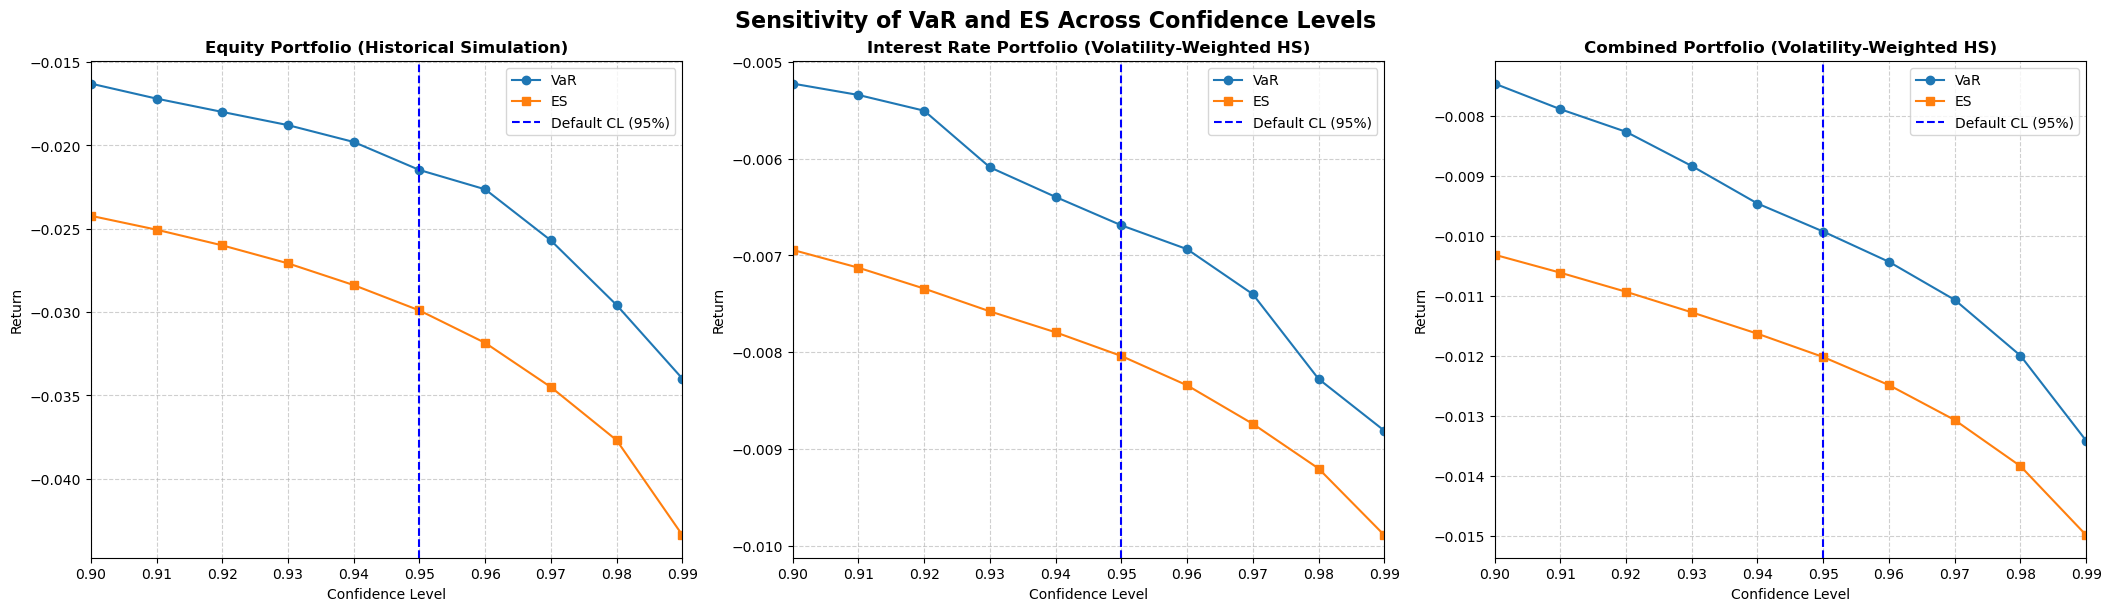

Sensitivity analysis plot saved as: 'PORTFOLIO ASSIGNMENT 2/Sensitivity_VaR_ES_Curves.png'


In [317]:
# === IMPORTS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# === PARAMETERS ===
alpha_default = 0.05  # For 95% confidence
confidence_levels = np.round(np.arange(0.90, 0.991, 0.01), 3)  # 90% to 99%

# === PORTFOLIO RETURNS ===
returns_equity = portfolio_returns['Equity'].dropna()
returns_interest = portfolio_returns['Interest Rate'].dropna()

# Align dates for Combined Portfolio
common_index = returns_equity.index.intersection(returns_interest.index)
returns_combined = 0.5 * returns_equity.loc[common_index] + 0.5 * returns_interest.loc[common_index]

# === VAR AND ES MODELS ===
def historical_var(returns, alpha):
    return np.percentile(returns, 100 * alpha)

def historical_es(returns, alpha):
    threshold = np.percentile(returns, 100 * alpha)
    return returns[returns <= threshold].mean()

def volatility_weighted_var(returns, alpha, lam=0.94):
    span = (2 / (1 - lam)) - 1
    vol = returns.ewm(span=span).std().dropna()
    normalized_returns = returns.loc[vol.index] / vol
    current_vol = vol.iloc[-1]
    adjusted = normalized_returns * current_vol
    return np.percentile(adjusted, 100 * alpha)

def volatility_weighted_es(returns, alpha, lam=0.94):
    span = (2 / (1 - lam)) - 1
    vol = returns.ewm(span=span).std().dropna()
    normalized_returns = returns.loc[vol.index] / vol
    current_vol = vol.iloc[-1]
    adjusted = normalized_returns * current_vol
    threshold = np.percentile(adjusted, 100 * alpha)
    return adjusted[adjusted <= threshold].mean()

# === SENSITIVITY FUNCTION ===
def sensitivity_confidence(returns, model_var, model_es):
    var_vals, es_vals = [], []
    for cl in confidence_levels:
        alpha = 1 - cl
        var_vals.append(model_var(returns, alpha))
        es_vals.append(model_es(returns, alpha))
    return np.array(var_vals), np.array(es_vals)

# === CALCULATE SENSITIVITIES ===
var_equity, es_equity = sensitivity_confidence(returns_equity, historical_var, historical_es)
var_interest, es_interest = sensitivity_confidence(returns_interest, volatility_weighted_var, volatility_weighted_es)
var_combined, es_combined = sensitivity_confidence(returns_combined, volatility_weighted_var, volatility_weighted_es)

# === PLOT SETUP ===
fig, axs = plt.subplots(1, 3, figsize=(21, 6), constrained_layout=True)
titles = [
    "Equity Portfolio (Historical Simulation)",
    "Interest Rate Portfolio (Volatility-Weighted HS)",
    "Combined Portfolio (Volatility-Weighted HS)"
]
vars_ = [var_equity, var_interest, var_combined]
ess_ = [es_equity, es_interest, es_combined]

for i in range(3):
    axs[i].plot(confidence_levels, vars_[i], label='VaR', marker='o')
    axs[i].plot(confidence_levels, ess_[i], label='ES', marker='s')
    axs[i].axvline(1 - alpha_default, color='blue', linestyle='--', label='Default CL (95%)')

    # Annotate text only (no arrows)
    idx_95 = np.where(np.isclose(confidence_levels, 0.95))[0]

    axs[i].set_title(titles[i], fontsize=12, fontweight='bold')
    axs[i].set_xlabel('Confidence Level')
    axs[i].set_ylabel('Return')
    axs[i].set_xlim(0.90, 0.99)
    axs[i].set_xticks(confidence_levels)
    axs[i].legend()
    axs[i].grid(True, linestyle='--', alpha=0.6)

fig.suptitle("Sensitivity of VaR and ES Across Confidence Levels", fontsize=16, fontweight='bold')
plt.savefig("PORTFOLIO ASSIGNMENT 2/Sensitivity_VaR_ES_Curves.png", dpi=300)
plt.show()

print("Sensitivity analysis plot saved as: 'PORTFOLIO ASSIGNMENT 2/Sensitivity_VaR_ES_Curves.png'")


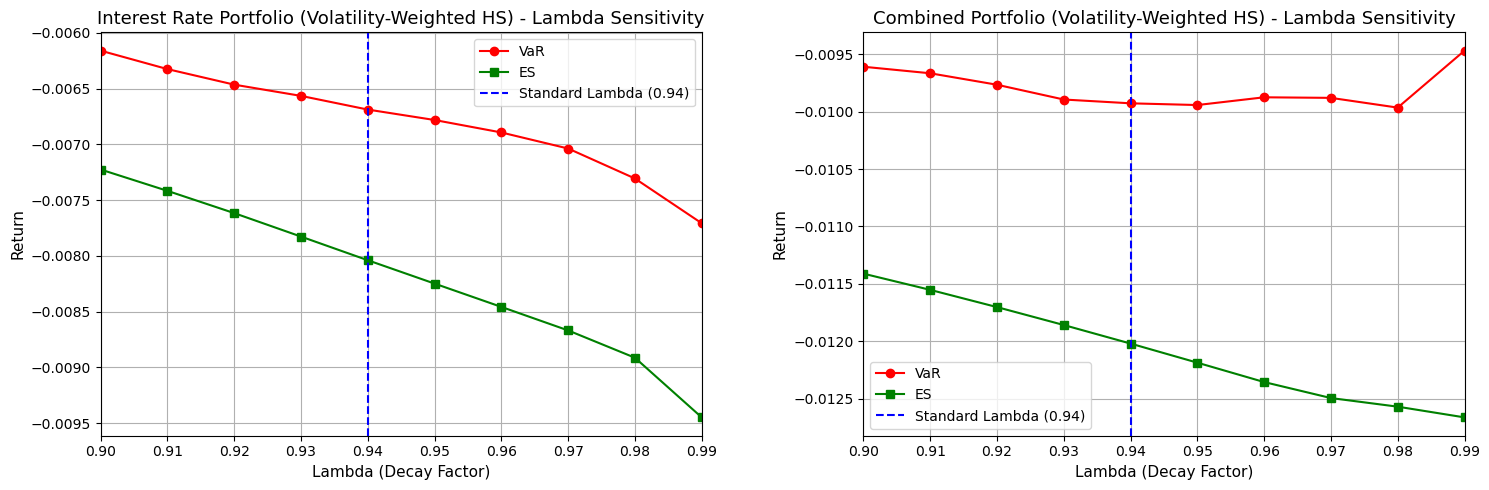

In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Lambda Range for Sensitivity Testing ===
lambdas = np.round(np.arange(0.90, 0.991, 0.01), 3)  # from 0.90 to 0.99, rounded for labeling

# === Volatility-Weighted VaR and ES Functions with Lambda ===
def volatility_weighted_var_lam(returns_window, alpha, lam):
    span = (2 / (1 - lam)) - 1
    vol = returns_window.ewm(span=span).std()
    vol = vol.dropna()
    
    normalized_returns = returns_window.loc[vol.index] / vol
    current_vol = vol.iloc[-1]
    adjusted_returns = normalized_returns * current_vol
    return np.percentile(adjusted_returns, 100 * alpha)

def volatility_weighted_es_lam(returns_window, alpha, lam):
    span = (2 / (1 - lam)) - 1
    vol = returns_window.ewm(span=span).std()
    vol = vol.dropna()
    
    normalized_returns = returns_window.loc[vol.index] / vol
    current_vol = vol.iloc[-1]
    adjusted_returns = normalized_returns * current_vol
    var_level = np.percentile(adjusted_returns, 100 * alpha)
    return adjusted_returns[adjusted_returns <= var_level].mean()

# === Sensitivity Function ===
def sensitivity_lambda(returns, alpha):
    var_list = []
    es_list = []
    for lam in lambdas:
        var = volatility_weighted_var_lam(returns, alpha, lam)
        es = volatility_weighted_es_lam(returns, alpha, lam)
        var_list.append(var)
        es_list.append(es)
    return np.array(var_list), np.array(es_list)

# === Fixed Alpha ===
alpha_fixed = 0.05  # 95% confidence

# === Run Sensitivity for Both Portfolios ===
var_interest_lambda, es_interest_lambda = sensitivity_lambda(returns_interest, alpha_fixed)
var_combined_lambda, es_combined_lambda = sensitivity_lambda(returns_combined, alpha_fixed)

# === Plotting ===
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

titles = [
    'Interest Rate Portfolio (Volatility-Weighted HS) - Lambda Sensitivity',
    'Combined Portfolio (Volatility-Weighted HS) - Lambda Sensitivity'
]
vars_ = [var_interest_lambda, var_combined_lambda]
ess_ = [es_interest_lambda, es_combined_lambda]

for i in range(2):
    axs[i].plot(lambdas, vars_[i], label='VaR', marker='o', color='red')
    axs[i].plot(lambdas, ess_[i], label='ES', marker='s', color='green')
    
    
    axs[i].axvline(0.94, color='blue', linestyle='--', label='Standard Lambda (0.94)')
    axs[i].set_title(titles[i], fontsize=13)
    axs[i].set_xlabel('Lambda (Decay Factor)', fontsize=11)
    axs[i].set_ylabel('Return', fontsize=11)
    axs[i].set_xlim(0.90, 0.99)
    axs[i].set_xticks(lambdas)
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout(w_pad=4)
plt.show()
